In [3]:
import pickle
import numpy as np 
import gzip
all_logits = pickle.load(gzip.open('gpt-2_output/all_logits5000_word_prompts.pickle.gz', 'rb'))
all_logits

[array([[[ -81.64417  , -160.41396  , -152.66937  , ...,  192.53424  ,
           190.6503   ,  192.5736   ],
         [ -83.31294  , -163.3606   , -155.75554  , ...,  195.60844  ,
           193.95073  ,  195.66473  ],
         [ -83.73698  , -165.03947  , -157.31506  , ...,  191.0691   ,
           189.29443  ,  191.10385  ],
         ...,
         [ -88.16809  , -169.24516  , -163.42642  , ...,  184.94798  ,
           183.7158   ,  184.97691  ],
         [ -89.15411  , -169.36166  , -161.99855  , ...,  185.407    ,
           184.36499  ,  185.44049  ],
         [ -81.3553   , -161.82532  , -155.31323  , ...,  200.46873  ,
           196.09521  ,  200.5211   ]],
 
        [[ -75.54504  , -114.948784 ,  -62.30545  , ...,   81.63484  ,
          -257.52982  ,   82.31576  ],
         [ -80.564766 , -117.98952  ,  -70.366104 , ...,   80.31335  ,
          -260.03366  ,   81.022575 ],
         [ -82.86659  , -122.07285  ,  -71.80587  , ...,   78.269    ,
          -262.12262  ,   78.972

In [4]:
all_logits[0].shape

(5, 50257, 100)

In [5]:
all_logits = all_logits[0]

In [4]:
num=100
base =10000
plt.plot(np.arange(num),np.logspace(1,0,num, base=base)/base)
plt.show()

NameError: name 'plt' is not defined

In [5]:
(np.logspace(1,0,10)/np.logspace(1,0,10).sum()).sum()

0.9999999999999999

In [7]:

tail_means = []
for _ in range(64): #32 random samples
    b = np.random.choice(np.arange(all_logits.shape[0])) # randomly sample a batch 
    t = np.random.choice(np.arange(all_logits[b].shape[1])) # randomly sample a timepoint

    sps = softmax(-np.sort(-all_logits[b, :, i]))
    #finding the tail without any alpha first
    sps_round= np.around(sps,2) # ROUNDING UP THE SPS!
    first = sps_round[1:] - sps_round[:-1]
    second = first[1:] - first[:-1]
    tail_id = second.shape[0]-np.argmax(np.flip(second)>0.001)

    tail_means.append(tail_id)
tail_mean = sum(tail_means)/len(tail_means)
print(tail_mean)

NameError: name 'i' is not defined

In [ ]:
torch.from_numpy(w).unsqueeze(0).unsqueeze(1).shape

In [8]:

import torch
w = (1-0.05)**np.arange(0,10)
print(w)
l = torch.ones((1,1,100000))
print(l.shape)
p = len(w)-1
out = torch.nn.functional.conv1d(l.double(),torch.from_numpy(w).unsqueeze(0).unsqueeze(1), padding=p )
out = alpha*out
out_red = out[:,:,p:]
print(out.shape)
print(out)
print(out_red.shape)
out_red

[1.         0.95       0.9025     0.857375   0.81450625 0.77378094
 0.73509189 0.6983373  0.66342043 0.63024941]
torch.Size([1, 1, 100000])
torch.Size([1, 1, 100009])
tensor([[[0.0315, 0.0647, 0.0996,  ..., 0.1426, 0.0975, 0.0500]]],
       dtype=torch.float64)
torch.Size([1, 1, 100000])


tensor([[[0.4013, 0.4013, 0.4013,  ..., 0.1426, 0.0975, 0.0500]]],
       dtype=torch.float64)

In [9]:
np.sum(w*l.numpy())

ValueError: operands could not be broadcast together with shapes (10,) (1,1,100000) 

In [10]:
w.astype(np.float32)

array([1.        , 0.95      , 0.9025    , 0.857375  , 0.81450623,
       0.77378094, 0.73509187, 0.6983373 , 0.66342044, 0.6302494 ],
      dtype=float32)

In [11]:
np.expand_dims(np.expand_dims(np.ones((30)), axis=0), axis=0).shape

(1, 1, 30)

In [31]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

def ema_calc(alpha, vals, reverse=False):
    ema = []
    for i in range(vals.shape[0]):
        if i == 0:
            ema.append(vals[i])
        else: 
            ema.append( (alpha*vals[i]) + ((1-alpha)*ema[i-1]) )
    if reverse:
        return np.flip(np.asarray(ema))
    else:
        return np.asarray(ema)

def nucleus_calc(threshs, vals):
    n_threshs = []
    for t in threshs: 
        n_threshs.append(np.argmax(np.cumsum(vals)>t)+1)
    return n_threshs

def sma_calc(n_prop, n, vals, tail_id, weights_type='linear', log_base =100, window_size=None):
    
    if window_size != None: 
        window = window_size
    else:
        window = int(n_prop*tail_id)+1 #int(n*n_prop)+1 #int(n_prop*tail_id)+1 #int(n*n_prop) # should really calculate this and N at the very start. 
    
    if weights_type=='linear':
        weights = np.linspace(1,0,window)/np.linspace(1,0,window).sum()
        #weights = np.linspace(1,0,window)/window
        
    elif weights_type=='log':
        weights=np.logspace(1,0,window,base=log_base)/np.logspace(1,0,window,base=log_base).sum()
        
    elif weights_type=='uniform':
        weights = np.ones((window))*(1/window)
    
    tail_size = vals.shape[0]-tail_id # this is the max size of the window
    
    if window>tail_size:
        print('window is too large, making it look across the whole tail')
        window=tail_size
    
    print('window being used:',window)
    sma = vals
    # can apply a convolution here that is not being trained!
    for i in range(0,vals.shape[0]-window):
        sma[i] =  np.sum( vals[i:i+window]*weights ) #np.mean(vals[i:i+window])
    return sma
break

def ema_eff(alpha,  vals, perc_acc=0.99 ):
    k = int(np.log(1-perc_acc)/np.log(1-alpha)) # this should be calculated at the start not in the loop!! 
    print('size of K for EMA', k)
    
    if k>vals.shape[0]: # CHECK THIS SHAPE MEASUREMENT
        k = vals.shape[0]
    
    # have something to check the tail id is less than the window size. 
    
    window_weights = (1-alpha)**np.arange(0,k)
    p = k-1
    # THIS CAN BE DONE IN A BATCH V EFFICIENTLY
    out = torch.nn.functional.conv1d(torch.from_numpy(vals).unsqueeze(0).unsqueeze(1).double(),torch.from_numpy(window_weights).unsqueeze(0).unsqueeze(1), padding=p )
    out = alpha*out[0,0,p:]
    print(out.shape)
    
    return out.numpy()
    
    
alpha = 0.05 #lower the alpha, smoother the curve and more weight placed on previous observations. 
eff_alpha = 0.05
#only below 0.1 does it really start to have any effect. 

threshs = [0.1, 0.25, 0.5, 0.75, 0.9] # for the nucleus sampling

N = all_logits.shape[1]

nt = [] #pd.DataFrame(columns=[threshs+['tail']])
for b in range(all_logits.shape[0]):
    for i in range(20): #(all_logits.shape[2]):
        sps_pure = softmax(-np.sort(-all_logits[b, :, i]))
        sps = softmax(-np.sort(-all_logits[b, :, i]))
        
        '''plt.plot(np.arange(0,50257),sps )
        plt.xlim([0,50])
        plt.show()'''
        
        indices = np.argsort(-all_logits[b, :, i])
        rev_sps = softmax(np.sort(all_logits[b, :, i]))
        
        #finding the tail without any alpha first
        sps_round= np.around(sps,2) # ROUNDING UP THE SPS!
        first = sps_round[1:] - sps_round[:-1]
        second = first[1:] - first[:-1]
        tail_id = second.shape[0]-np.argmax(np.flip(second)>0.001) # gradient calc fix. 
        tail_id_org = tail_id
        if tail_id<=0:
            tail_id=1
        #tail_id = second.shape[0]-np.argmax(np.flip(second)>0.001) # still want the first one that hits
        
        # now looking for better tails, going to use a SMA with differnet proportions of the N as a window
        
        sma_tails = []
        percentage_of_tail =[0.5, 0.9, 0.95, 1] #, 1.5, 3] #[ 2, 2.5,3,3.5]#[0.1, 0.25, 0.5, 0.75, 0.9]
        
        #percentage_of_window = [0.0001, 0.0003, 0.0005 , 0.001]
        #for window_proportion in percentage_of_window:
        for tail_width_multiple in percentage_of_tail:
            log_base = 10
            sps_sma = sma_calc(tail_width_multiple, N, sps, tail_id, 
                               weights_type='linear', log_base=log_base, 
                               window_size=None) # dont need to reverse it if not using EMA now. 
            sps_round= np.around(sps_sma,2) #sps_sma#np.around(sps_sma,2) # ROUNDING UP THE SPS!
            first = sps_round[1:] - sps_round[:-1]
            second = first[1:] - first[:-1]
            deriv_thresh = 0.001
            
            '''plt.plot(np.arange(0,second.shape[0]),second )
            plt.xlim([0,50])
            plt.axhline(deriv_thresh, color='orange', linestyle='solid')
            plt.title('2nd derivative post quantization')
            plt.show()'''
            
            tail_id_sma = second.shape[0]-np.argmax(np.flip(second)>deriv_thresh) -2
            if tail_id_sma <=0:
                tail_id_sma=1
            sma_tails.append(tail_id_sma)
            print('tail id sma', tail_id_sma)
            
            '''plt.plot(np.arange(0,50257),sps_sma)
            plt.axvline(tail_id_sma, color='orange', linestyle='solid')
            plt.xlim([0,50])
            plt.title('SMA Plot '+str(window_proportion))
            plt.show()
            print('==============')'''
        
        # finding the sps_ema so that I can compare it.
        
        #########################################
        ema_eff_tails = []
        for test_alpha in [0.01, 0.05, 0.1, 0.5]:
            print('alpha used', test_alpha)
            sps_ema_eff = ema_eff(test_alpha, sps_pure, perc_acc=0.99 ) #eff_alpha
            
            scaler = sps_pure[0]/sps_ema_eff[0]
            
            sps_ema_eff = sps_ema_eff*scaler
            
            sps_round= np.around(sps_ema_eff,1) # ROUNDING UP THE SPS!
            first = sps_round[1:] - sps_round[:-1]
            second = first[1:] - first[:-1]
            tail_id_ema_eff = second.shape[0]-np.argmax(np.flip(second)>0.001)
            ema_eff_tails.append(tail_id_ema_eff)
            print('ugh', np.argmax(np.flip(second)>0.001))
            print('tail id ema eff', tail_id_ema_eff)
            
            plt.plot(np.arange(0,50257),sps_ema_eff)
            plt.axvline(tail_id_ema_eff, color='purple', linestyle='solid')
            plt.xlim([0,50])
            #plt.title('SMA Plot '+str(window_proportion))
            plt.show()
            print('==============')
            
            plt.plot(np.arange(0,50257),sps_round)
            plt.axvline(tail_id_ema_eff, color='green', linestyle='solid')
            plt.xlim([0,50])
            #plt.title('SMA Plot '+str(window_proportion))
            plt.show()
            print('==============')

            plt.plot(np.arange(0,second.shape[0]),second )
            plt.xlim([0,50])
            plt.axhline(deriv_thresh, color='orange', linestyle='solid')
            plt.title('2nd derivative post quantization for EMA eff')
            plt.show()
        
        ###########################################
        
        sps = sps_pure 
        rev_sps = softmax(np.sort(all_logits[b, :, i]))
        sps_ema = ema_calc(alpha, rev_sps, reverse=True) #HERE I AM SETTING THE SPS TO BE FROM THE EMA! 
        sps_round= np.around(sps_ema,2) # ROUNDING UP THE SPS!
        first = sps_round[1:] - sps_round[:-1]
        second = first[1:] - first[:-1]
        tail_id_ema_stand = second.shape[0]-np.argmax(np.flip(second)>0.001) # this is what is actually finding where the tail is via the 2nd derivative. 
        ids_above_tail = indices[:tail_id_ema_stand] # use these indices to determine what the words are and their probabilities. 
        tail_free_probs = softmax(all_logits[b, ids_above_tail, i]) # it is already applying the softmax too
        # choose one of these: 
        print('tail free probs', tail_free_probs)
        word_chosen = np.random.choice(ids_above_tail, size=1, replace=False, p=tail_free_probs)
        print('the word chosen by TFS', word_chosen)
        
        tail_cdf = np.cumsum(sps[:tail_id_ema_stand])[-1]
        print('spsp ', sps.shape)
        print('second shape', second.shape)
        #plotting of the second derivative
        plt.plot(np.arange(0,second.shape[0]),second )
        plt.xlim([0,50])
        plt.axhline(0.001, color='r', linestyle='solid')
        plt.title('2nd derivative post quantization')
        plt.show()
        
        plt.plot(np.arange(0,50257),sps_ema)
        plt.axvline(tail_id_ema_stand, color='purple', linestyle='solid')
        plt.xlim([0,50])
        #plt.title('SMA Plot '+str(window_proportion))
        plt.show()
        print('==============')
        
        #windows = [2]
        #var_sums, smallest_gap = variance_windows_calc(windows, second)
        #tail_id = (np.argmax(var_sums<0.001) * smallest_gap) -1
        #tail_id = np.argmax(second[1:]>-0.01)+2
        print('Ema!', 'timepoint', i, 'tail id', tail_id)

        n_threshs = nucleus_calc(threshs, sps)
        for c, t in zip(['orange', 'green', 'purple', 'gray', 'black'],n_threshs):
            plt.axvline(t, color=c, linestyle='dashed')
        #for t in sma_tails:
        #    plt.axvline(t, color='orange', linestyle='solid')
        print('nucleus thresholds', n_threshs)
        print('sma perc', percentage_of_tail)
        #print('sma perc', percentage_of_window)
        print('sma tails', sma_tails)
        plt.plot(np.arange(0,50257),sps )
        plt.xlim([0,50])
        plt.axvline(tail_id_org, color='r', linestyle='solid', label='TFS None')
        plt.axvline(tail_id_ema_stand, color='green', linestyle='solid', label='EMA Stand')
        #plt.axvline(tail_id_sma, color='orange', linestyle='solid', label='SMA')
        for eff_ind, test_alpha in enumerate([0.01, 0.05, 0.1, 0.5]):
            plt.axvline(ema_eff_tails[eff_ind], linestyle='solid', label='EMA Eff, alpha:'+str(test_alpha))
        print('EMA eff',tail_id_ema_eff)
        plt.legend()
        plt.show()
        n_threshs.append(tail_id)
        n_threshs.append(sma_tails[1])
        n_threshs.append(sma_tails[2])
        n_threshs.append(sma_tails[3])
        n_threshs.append(tail_cdf)
        nt.append( n_threshs  )
        '''print('the distribution of the probabilities of options after TFS')
        plt.plot(np.arange(tail_free_probs.shape[0]), tail_free_probs)
        plt.show()'''
        print('=============')
        print('=============')
        
    print('batch', b, '===========================')

SyntaxError: 'break' outside loop (<ipython-input-31-466d21846c15>, line 56)

## Dynamic Quantization test

In [19]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch
break
def ema_eff(alpha,  vals, perc_acc=0.99 ):
    k = int(np.log(1-perc_acc)/np.log(1-alpha)) # this should be calculated at the start not in the loop!! 
    print('size of K for EMA', k)
    
    if k>vals.shape[0]: # CHECK THIS SHAPE MEASUREMENT
        k = vals.shape[0]
    
    # have something to check the tail id is less than the window size. 
    
    window_weights = (1-alpha)**np.arange(0,k)
    p = k-1
    # THIS CAN BE DONE IN A BATCH V EFFICIENTLY
    out = torch.nn.functional.conv1d(torch.from_numpy(vals).unsqueeze(0).unsqueeze(1).double(),torch.from_numpy(window_weights).unsqueeze(0).unsqueeze(1), padding=p )
    out = alpha*out[0,0,p:]
    print(out.shape)
    
    return out.numpy()
    
    
alpha = 0.05 #lower the alpha, smoother the curve and more weight placed on previous observations. 
eff_alpha = 0.05
#only below 0.1 does it really start to have any effect. 

threshs = [0.1, 0.25, 0.5, 0.75, 0.9] # for the nucleus sampling

N = all_logits.shape[1]

nt = [] #pd.DataFrame(columns=[threshs+['tail']])
for b in range(all_logits.shape[0]):
    for i in range(20): #(all_logits.shape[2]):
        
        all_tails = []
        
        sps = softmax(-np.sort(-all_logits[b, :, i]))        
        #finding the tail without any alpha first
        sps_round= np.around(sps,2) # ROUNDING UP THE SPS!
        first = sps_round[1:] - sps_round[:-1]
        second = first[1:] - first[:-1]
        tail_id = second.shape[0]-np.argmax(np.flip(second)>0) # gradient calc fix. 
        print('natural tail is at:', tail_id)
        all_tails.append(tail_id)
        
        plt.plot(np.arange(0,50257),sps)
        plt.axvline(tail_id, color='purple', linestyle='solid')
        plt.xlim([0,50])
        #plt.title('SMA Plot '+str(window_proportion))
        plt.show()
        print('==============')
        
        for r in [1,2,3,4]:
            
            print('rounding amount is:', r)
        
            #sps_pure = softmax(-np.sort(-all_logits[b, :, i]))
            sps = softmax(-np.sort(-all_logits[b, :, i]))

            #finding the tail without any alpha first
            sps_round= np.around(sps,r) # ROUNDING UP THE SPS!
            first = sps_round[1:] - sps_round[:-1]
            second = first[1:] - first[:-1]
            tail_id = second.shape[0]-np.argmax(np.flip(second)>0) # gradient calc fix. 
            
            print('tail id is at:', tail_id)
            
            all_tails.append(tail_id)

            plt.plot(np.arange(0,50257),sps)
            plt.axvline(tail_id, color='purple', linestyle='solid')
            plt.xlim([0,50])
            plt.title('Rounding at: '+str(r))
            plt.show()
            
            plt.plot(np.arange(0,50257),sps_round)
            plt.axvline(tail_id, color='purple', linestyle='solid')
            plt.xlim([0,50])
            plt.title('Rounded plot. Rounding at: '+str(r))
            plt.show()

            plt.plot(np.arange(0,second.shape[0]),second )
            plt.xlim([0,50])
            plt.axhline(0.001, color='r', linestyle='solid')
            plt.title('2nd derivative post quantization')
            plt.show()
            
            print('==============')
        
        plt.plot(np.arange(0,50257),sps)
        counter=0
        for c, t in zip(['orange', 'green', 'purple', 'gray', 'black'],all_tails): 
            plt.axvline(t, color=c, linestyle='solid', label=counter)
            counter+=1
        plt.xlim([0,50])
        plt.legend()
        #plt.title('SMA Plot '+str(window_proportion))
        plt.show()
        
        print('=================')
        print('=================')
        print('=================')
        
    print('batch', b, '===========================')

SyntaxError: 'break' outside loop (<ipython-input-19-aebbb84cddbb>, line 8)

# No Rounding Allowed

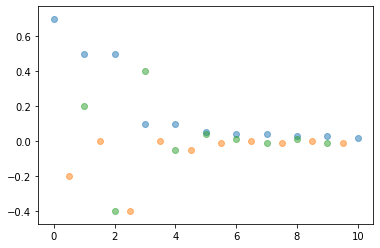

In [73]:
sps = np.asarray([ 0.7,0.5,0.5,0.1,0.1,0.05,0.04,0.04, 0.03, 0.03, 0.02])
first = sps[1:] - sps[:-1]
second = first[1:] - first[:-1]
plt.scatter(range(len(sps)), sps, alpha=0.5)
plt.scatter(np.asarray(range(len(first)))+0.5, first, alpha=0.5)
plt.scatter(np.asarray(range(len(second)))+1, second, alpha=0.5)

In [26]:
second

array([ 0. , -0.4,  0.9, -0.5,  0.3, -0.2, -0.3,  0.6, -0.3,  0. ])

In [27]:
gap = second[1:] - second[:-1]
gap

array([-0.4,  1.3, -1.4,  0.8, -0.5, -0.1,  0.9, -0.9,  0.3])

natural tail is at: 30
neg inds [ 5 13 28]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  4  6 14 29]
weights [0.9679335  0.02256532 0.00118765 0.0023753  0.0023753  0.00118765
 0.00118765 0.00118765]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 4


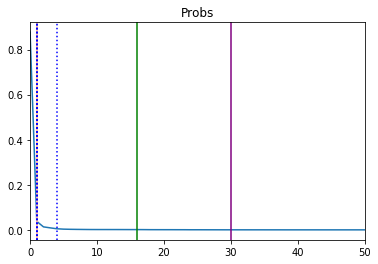

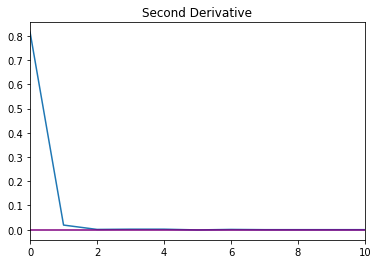

natural tail is at: 66
neg inds [ 0  3  5  7  9 11 12 16 24 64]
 neg weighted mean tail 4
pos inds [ 1  2  4  6  8 10 13 17 25 65]
weights [0.2468354  0.6392405  0.00632912 0.06962025 0.00632912 0.00632912
 0.00632912 0.00632911 0.00632911 0.00632911]
pos weighted mean tail 3
combo tail is:  4
threshold: 0.25 tail id: 2
threshold: 0.75 tail id: 3
threshold: 0.9 tail id: 7
threshold: 0.95 tail id: 9
threshold: 0.99 tail id: 26


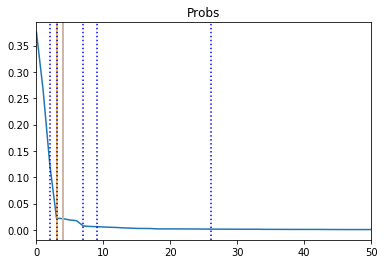

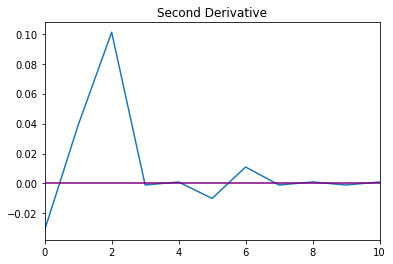

natural tail is at: 107
neg inds [  2   6   9  10  15  18  20  23  28  35  48 105]
 neg weighted mean tail 14
pos inds [  0   1   3   4   5   7   8  11  12  13  14  16  19  21  24  29  36  49
 106]
weights [5.1020408e-01 2.1768704e-01 3.4013595e-02 5.4421771e-02 1.3605443e-02
 5.4421771e-02 2.0408165e-02 2.7210873e-02 6.8027214e-03 6.3355272e-09
 6.8027154e-03 6.8027214e-03 6.8027214e-03 6.8027214e-03 6.8027182e-03
 6.8027214e-03 6.8027200e-03 6.8027209e-03 6.8027209e-03]
pos weighted mean tail 4
combo tail is:  6
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 7
threshold: 0.9 tail id: 13
threshold: 0.95 tail id: 25
threshold: 0.99 tail id: 106


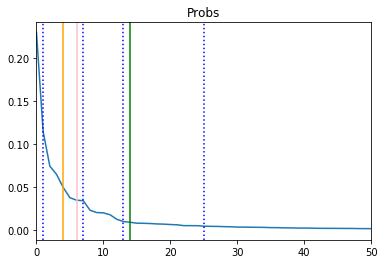

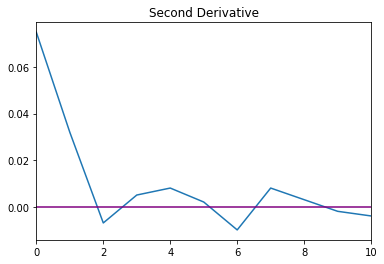

natural tail is at: 9
neg inds [2 7]
 neg weighted mean tail 5
pos inds [0 1 3 8]
weights [0.98078984 0.01600854 0.00213447 0.00106724]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


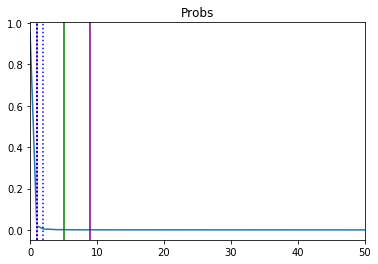

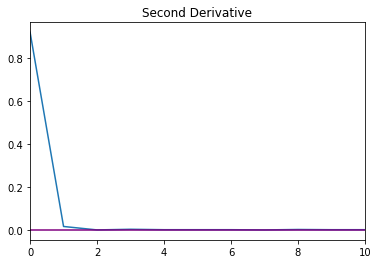

natural tail is at: 53
neg inds [ 4  7 11 19 51]
 neg weighted mean tail 19
pos inds [ 0  1  2  3  5  6  8 12 20 52]
weights [0.72957206 0.22762649 0.02918289 0.00194552 0.00194553 0.00194552
 0.00194553 0.00194553 0.00194553 0.00194553]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 12


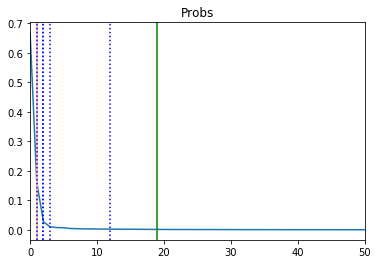

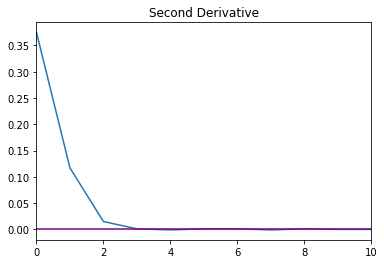

natural tail is at: 46
neg inds [ 2  4  5  7 11 14 19 26 44]
 neg weighted mean tail 9
pos inds [ 0  1  3  6  8 10 12 13 15 20 27 45]
weights [9.4625419e-01 1.6286619e-03 3.4201957e-02 6.5146596e-03 1.6286634e-03
 1.6286649e-03 7.5840606e-10 1.6286641e-03 1.6286649e-03 1.6286644e-03
 1.6286647e-03 1.6286647e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 16


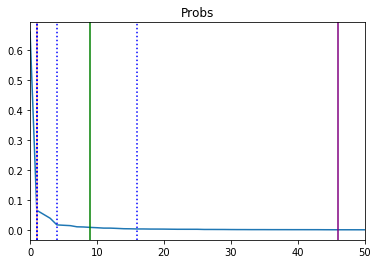

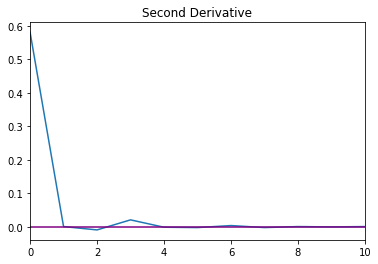

natural tail is at: 58
neg inds [ 2  5  8 10 15 30 56]
 neg weighted mean tail 12
pos inds [ 0  1  3  6  7  9 11 16 17 31 57]
weights [6.3053107e-01 3.3407080e-01 1.7699115e-02 4.4247778e-03 2.2123898e-03
 2.2123898e-03 2.2123889e-03 5.1511206e-10 2.2123894e-03 2.2123896e-03
 2.2123896e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 18


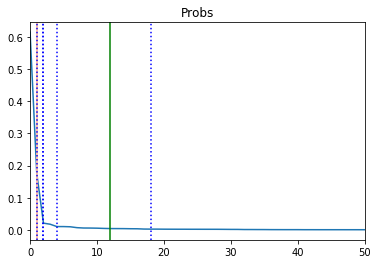

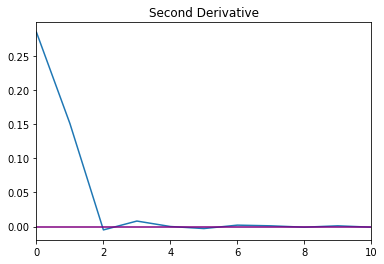

natural tail is at: 23
neg inds [ 3  8 21]
 neg weighted mean tail 11
pos inds [ 0  1  2  4  5  9 22]
weights [0.97970694 0.01127396 0.00450958 0.0011274  0.0011274  0.0011274
 0.0011274 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


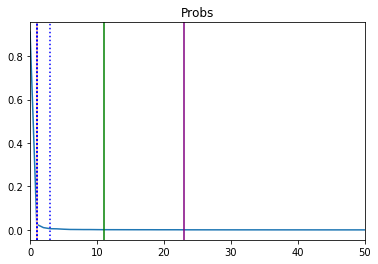

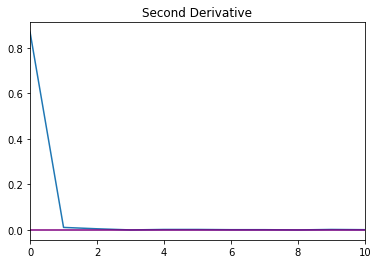

natural tail is at: 38
neg inds [ 1  3  6  8 16 36]
 neg weighted mean tail 4
pos inds [ 0  2  4  5  7  9 17 37]
weights [0.9092308  0.08153848 0.00153846 0.00153846 0.00153846 0.00153846
 0.00153846 0.00153846]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 8


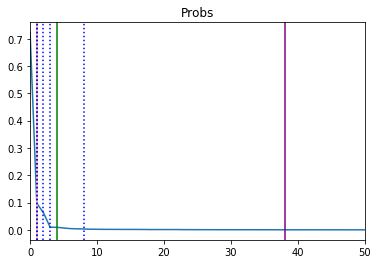

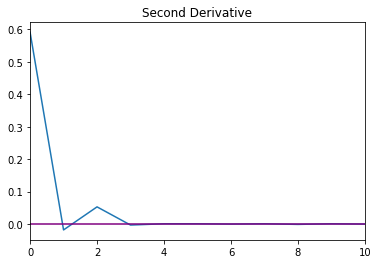

natural tail is at: 48
neg inds [ 4  7  8 12 14 17 25 46]
 neg weighted mean tail 18
pos inds [ 0  1  2  3  5 11 13 15 18 26 47]
weights [0.8670989  0.11507294 0.00162075 0.00486224 0.00162075 0.00162075
 0.00162075 0.00162075 0.00162075 0.00162075 0.00162075]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


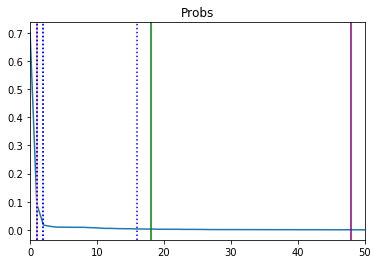

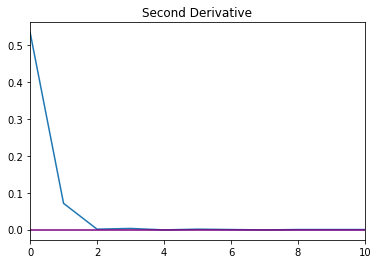

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


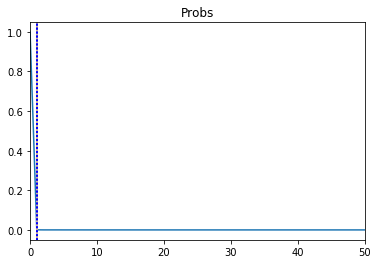

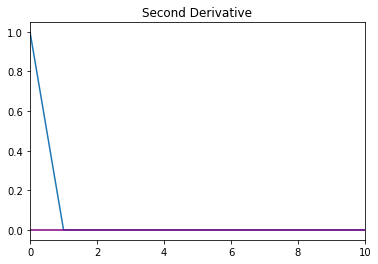

natural tail is at: 14
neg inds [ 3 12]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 13]
weights [0.9849301  0.00968784 0.00215285 0.00215285 0.00107643]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


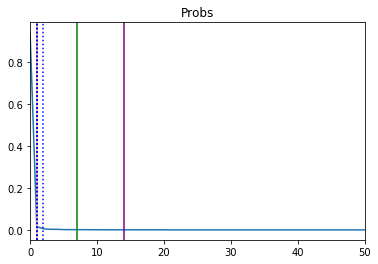

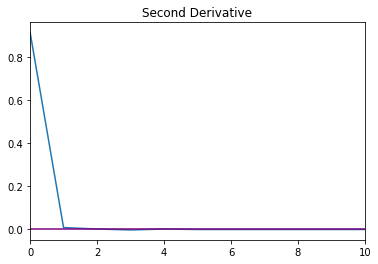

natural tail is at: 23
neg inds [ 1  5 21]
 neg weighted mean tail 10
pos inds [ 0  2  3  4  6 22]
weights [0.99232465 0.00109649 0.00219298 0.00219298 0.00109649 0.00109649]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


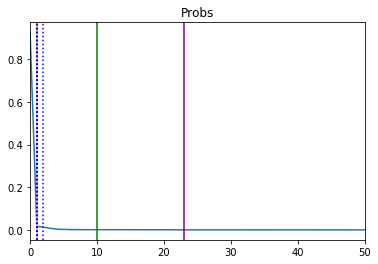

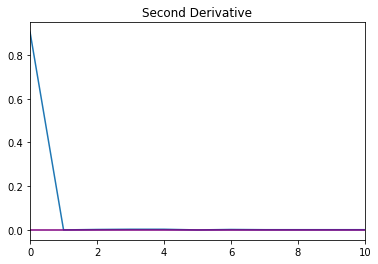

natural tail is at: 46
neg inds [ 4  7 11 12 14 21 44]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  5  8 13 15 22 45]
weights [0.5934066  0.38241762 0.00439561 0.0043956  0.0021978  0.00439561
 0.0021978  0.0021978  0.0021978  0.0021978 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


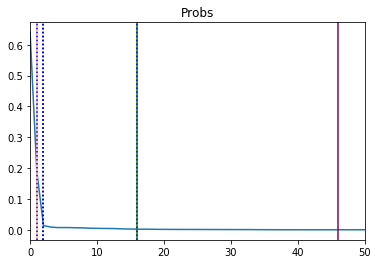

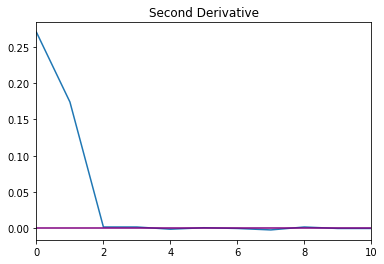

natural tail is at: 17
neg inds [ 4 15]
 neg weighted mean tail 15
pos inds [ 0  1  2  3  5 16]
weights [9.9357605e-01 3.2119912e-03 4.9856669e-10 1.0706638e-03 1.0706639e-03
 1.0706639e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


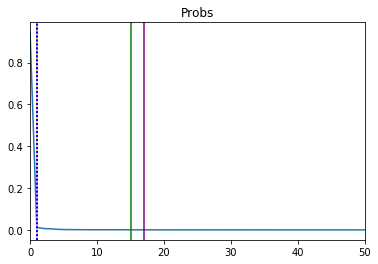

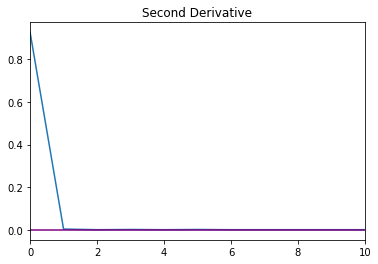

natural tail is at: 25
neg inds [ 1  6 23]
 neg weighted mean tail 8
pos inds [ 0  2  3  4  7 24]
weights [0.984091   0.01136364 0.00113636 0.00113636 0.00113636 0.00113636]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


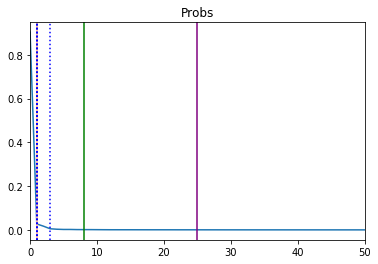

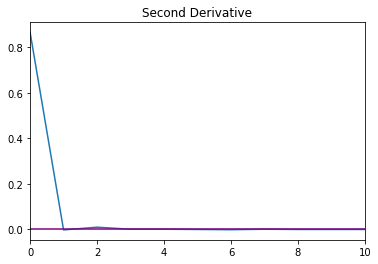

natural tail is at: 40
neg inds [ 2  6 10 14 38]
 neg weighted mean tail 6
pos inds [ 0  1  3  4  5  7 11 15 39]
weights [0.8967468  0.07637906 0.01697312 0.00282886 0.00141443 0.00141443
 0.00141443 0.00141443 0.00141443]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 7


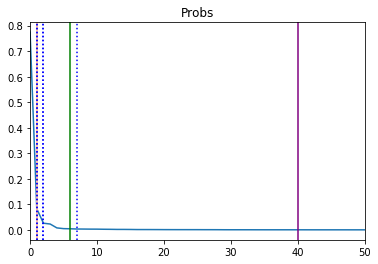

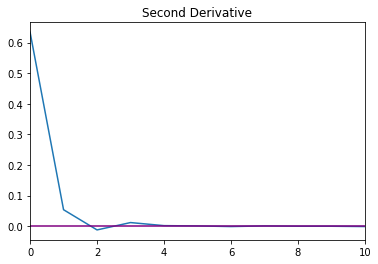

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


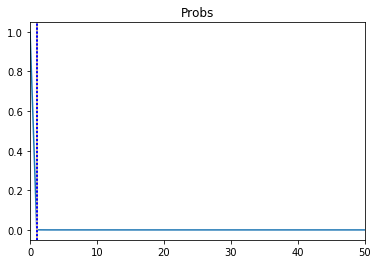

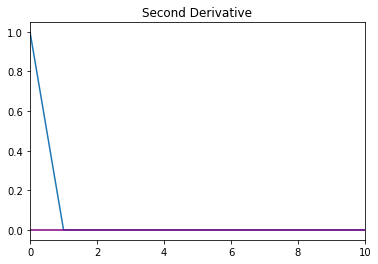

natural tail is at: 15
neg inds [ 1 13]
 neg weighted mean tail 7
pos inds [ 0  2  3 14]
weights [0.99687827 0.00104058 0.00104058 0.00104058]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


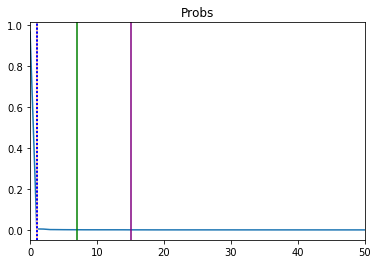

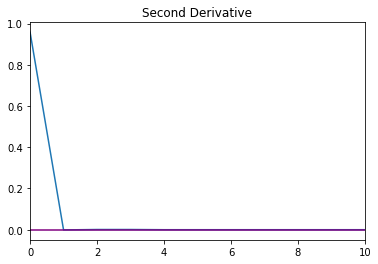

natural tail is at: 12
neg inds [ 3 10]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 11]
weights [0.99169266 0.00519211 0.00103842 0.00103842 0.00103842]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


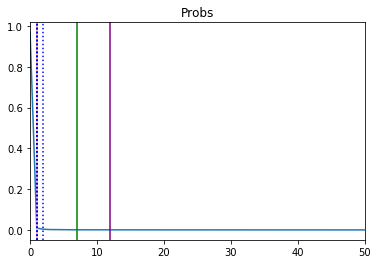

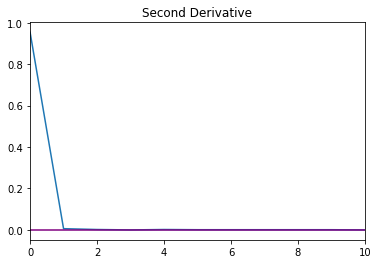

natural tail is at: 30
neg inds [ 5 13 28]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  4  6 14 29]
weights [0.9679335  0.02256532 0.00118765 0.0023753  0.0023753  0.00118765
 0.00118765 0.00118765]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 4


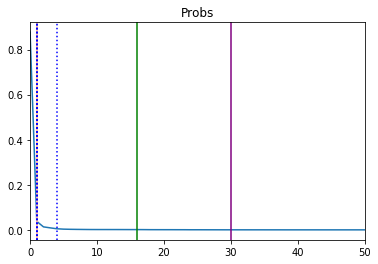

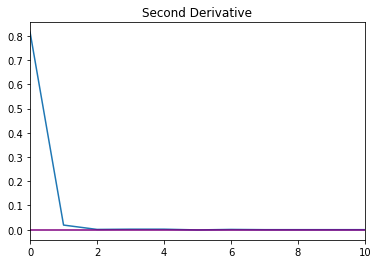

natural tail is at: 66
neg inds [ 0  3  5  7  9 11 12 16 24 64]
 neg weighted mean tail 4
pos inds [ 1  2  4  6  8 10 13 17 25 65]
weights [0.2468354  0.6392405  0.00632912 0.06962025 0.00632912 0.00632912
 0.00632912 0.00632911 0.00632911 0.00632911]
pos weighted mean tail 3
combo tail is:  4
threshold: 0.25 tail id: 2
threshold: 0.75 tail id: 3
threshold: 0.9 tail id: 7
threshold: 0.95 tail id: 9
threshold: 0.99 tail id: 26


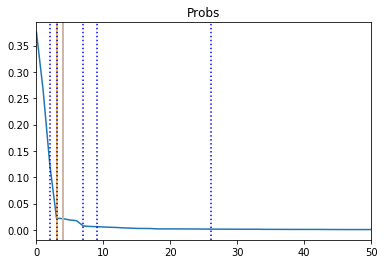

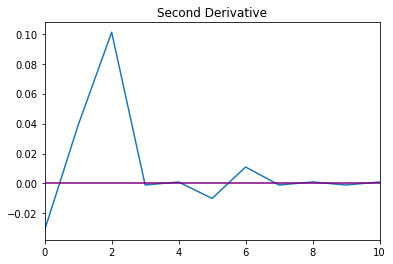

natural tail is at: 107
neg inds [  2   6   9  10  15  18  20  23  28  35  48 105]
 neg weighted mean tail 14
pos inds [  0   1   3   4   5   7   8  11  12  13  14  16  19  21  24  29  36  49
 106]
weights [5.1020408e-01 2.1768704e-01 3.4013595e-02 5.4421771e-02 1.3605443e-02
 5.4421771e-02 2.0408165e-02 2.7210873e-02 6.8027214e-03 6.3355272e-09
 6.8027154e-03 6.8027214e-03 6.8027214e-03 6.8027214e-03 6.8027182e-03
 6.8027214e-03 6.8027200e-03 6.8027209e-03 6.8027209e-03]
pos weighted mean tail 4
combo tail is:  6
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 7
threshold: 0.9 tail id: 13
threshold: 0.95 tail id: 25
threshold: 0.99 tail id: 106


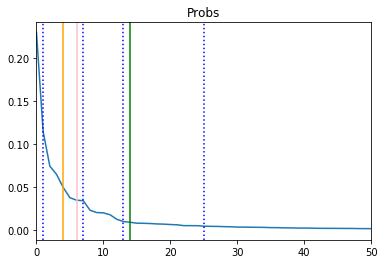

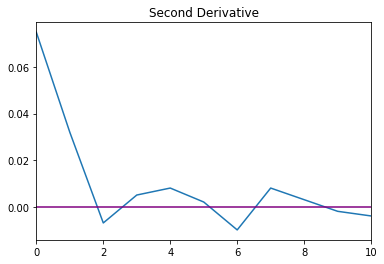

natural tail is at: 9
neg inds [2 7]
 neg weighted mean tail 5
pos inds [0 1 3 8]
weights [0.98078984 0.01600854 0.00213447 0.00106724]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


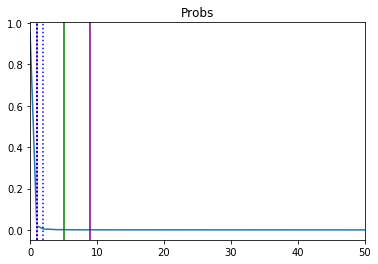

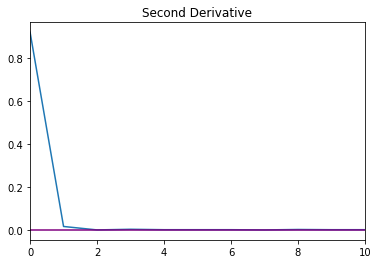

natural tail is at: 53
neg inds [ 4  7 11 19 51]
 neg weighted mean tail 19
pos inds [ 0  1  2  3  5  6  8 12 20 52]
weights [0.72957206 0.22762649 0.02918289 0.00194552 0.00194553 0.00194552
 0.00194553 0.00194553 0.00194553 0.00194553]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 12


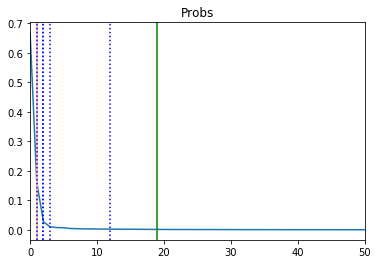

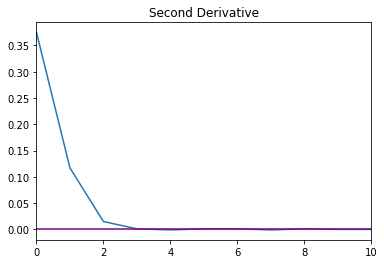

natural tail is at: 46
neg inds [ 2  4  5  7 11 14 19 26 44]
 neg weighted mean tail 9
pos inds [ 0  1  3  6  8 10 12 13 15 20 27 45]
weights [9.4625419e-01 1.6286619e-03 3.4201957e-02 6.5146596e-03 1.6286634e-03
 1.6286649e-03 7.5840606e-10 1.6286641e-03 1.6286649e-03 1.6286644e-03
 1.6286647e-03 1.6286647e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 16


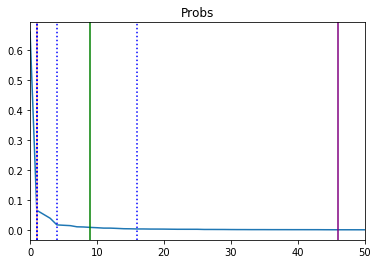

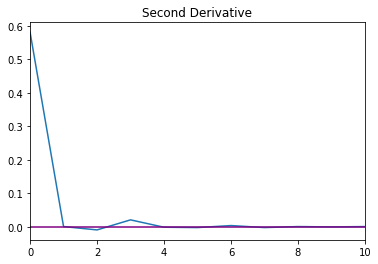

natural tail is at: 58
neg inds [ 2  5  8 10 15 30 56]
 neg weighted mean tail 12
pos inds [ 0  1  3  6  7  9 11 16 17 31 57]
weights [6.3053107e-01 3.3407080e-01 1.7699115e-02 4.4247778e-03 2.2123898e-03
 2.2123898e-03 2.2123889e-03 5.1511206e-10 2.2123894e-03 2.2123896e-03
 2.2123896e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 18


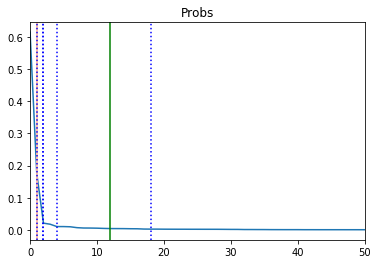

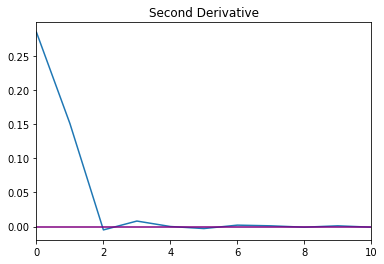

natural tail is at: 23
neg inds [ 3  8 21]
 neg weighted mean tail 11
pos inds [ 0  1  2  4  5  9 22]
weights [0.97970694 0.01127396 0.00450958 0.0011274  0.0011274  0.0011274
 0.0011274 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


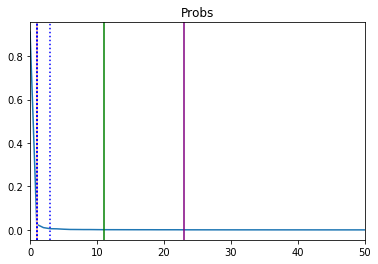

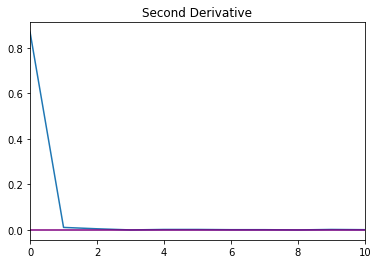

natural tail is at: 38
neg inds [ 1  3  6  8 16 36]
 neg weighted mean tail 4
pos inds [ 0  2  4  5  7  9 17 37]
weights [0.9092308  0.08153848 0.00153846 0.00153846 0.00153846 0.00153846
 0.00153846 0.00153846]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 8


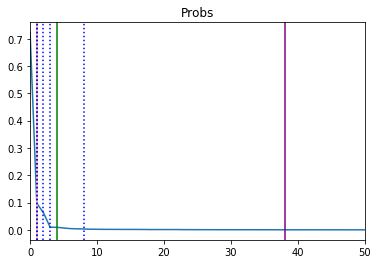

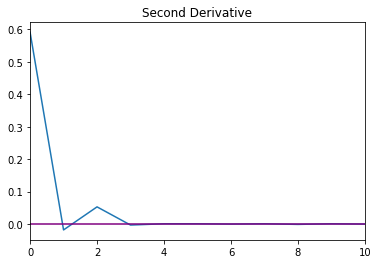

natural tail is at: 48
neg inds [ 4  7  8 12 14 17 25 46]
 neg weighted mean tail 18
pos inds [ 0  1  2  3  5 11 13 15 18 26 47]
weights [0.8670989  0.11507294 0.00162075 0.00486224 0.00162075 0.00162075
 0.00162075 0.00162075 0.00162075 0.00162075 0.00162075]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


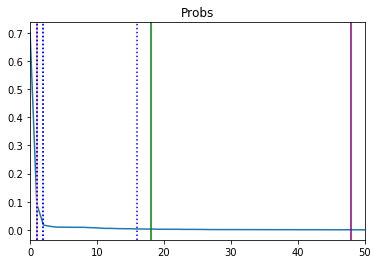

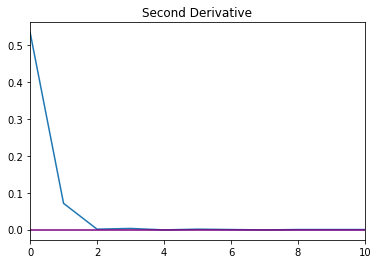

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


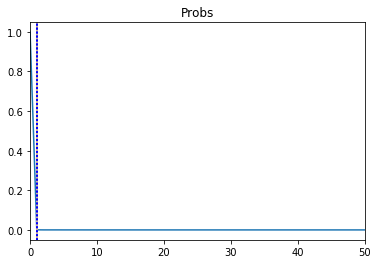

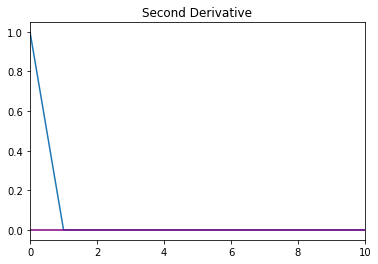

natural tail is at: 14
neg inds [ 3 12]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 13]
weights [0.9849301  0.00968784 0.00215285 0.00215285 0.00107643]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


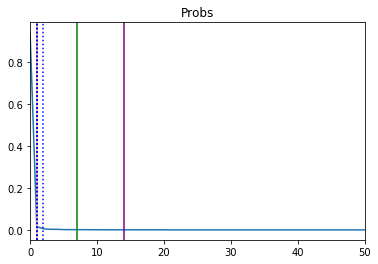

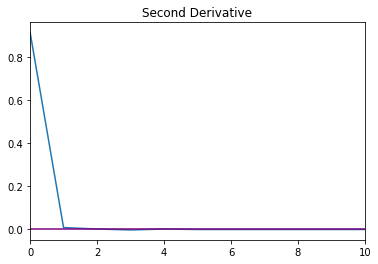

natural tail is at: 23
neg inds [ 1  5 21]
 neg weighted mean tail 10
pos inds [ 0  2  3  4  6 22]
weights [0.99232465 0.00109649 0.00219298 0.00219298 0.00109649 0.00109649]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


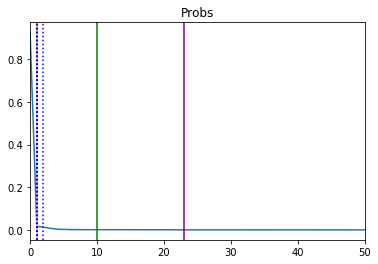

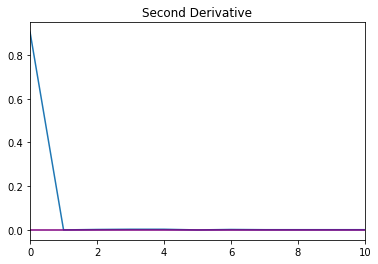

natural tail is at: 46
neg inds [ 4  7 11 12 14 21 44]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  5  8 13 15 22 45]
weights [0.5934066  0.38241762 0.00439561 0.0043956  0.0021978  0.00439561
 0.0021978  0.0021978  0.0021978  0.0021978 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


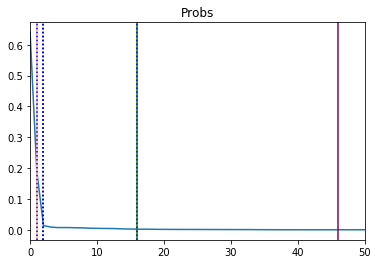

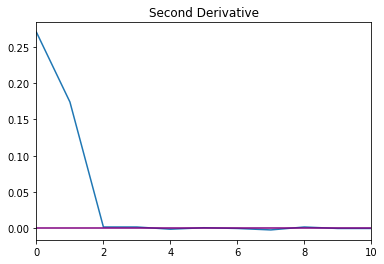

natural tail is at: 17
neg inds [ 4 15]
 neg weighted mean tail 15
pos inds [ 0  1  2  3  5 16]
weights [9.9357605e-01 3.2119912e-03 4.9856669e-10 1.0706638e-03 1.0706639e-03
 1.0706639e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


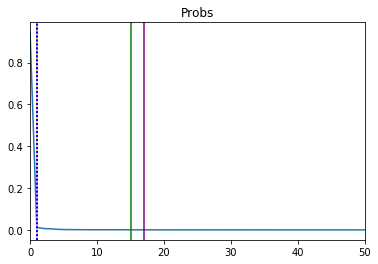

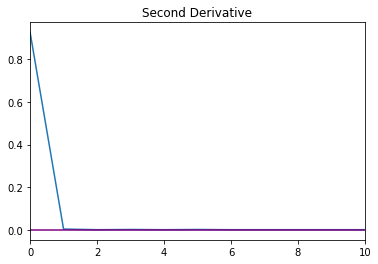

natural tail is at: 25
neg inds [ 1  6 23]
 neg weighted mean tail 8
pos inds [ 0  2  3  4  7 24]
weights [0.984091   0.01136364 0.00113636 0.00113636 0.00113636 0.00113636]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


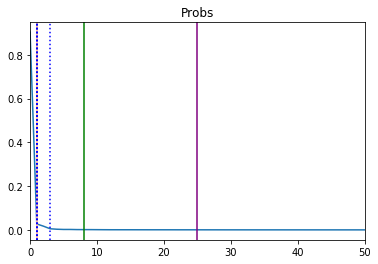

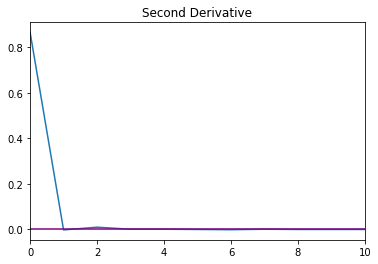

natural tail is at: 40
neg inds [ 2  6 10 14 38]
 neg weighted mean tail 6
pos inds [ 0  1  3  4  5  7 11 15 39]
weights [0.8967468  0.07637906 0.01697312 0.00282886 0.00141443 0.00141443
 0.00141443 0.00141443 0.00141443]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 7


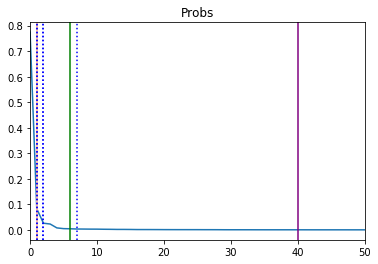

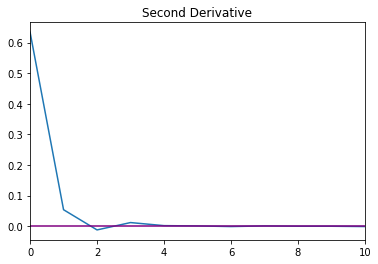

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


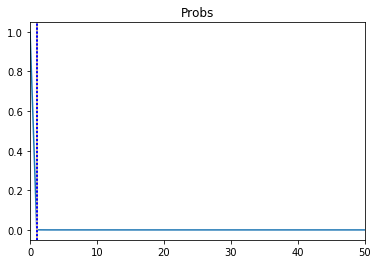

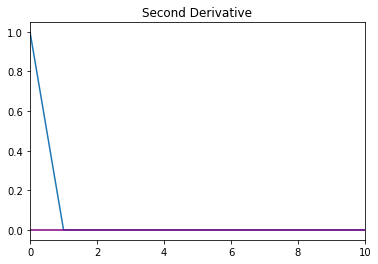

natural tail is at: 15
neg inds [ 1 13]
 neg weighted mean tail 7
pos inds [ 0  2  3 14]
weights [0.99687827 0.00104058 0.00104058 0.00104058]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


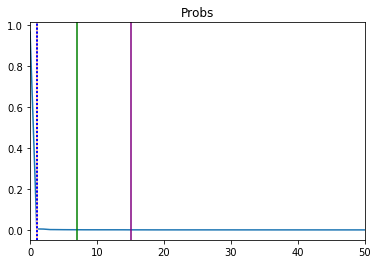

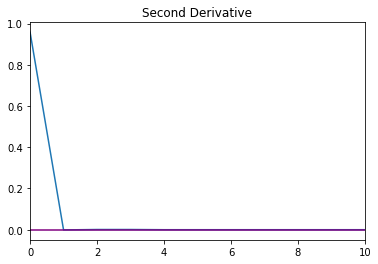

natural tail is at: 12
neg inds [ 3 10]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 11]
weights [0.99169266 0.00519211 0.00103842 0.00103842 0.00103842]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


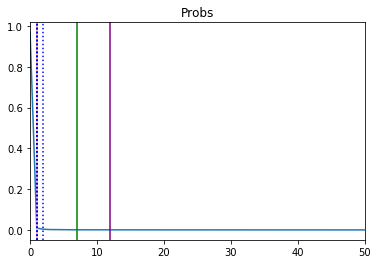

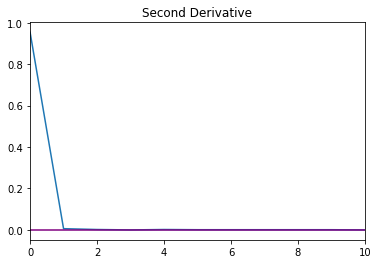

natural tail is at: 30
neg inds [ 5 13 28]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  4  6 14 29]
weights [0.9679335  0.02256532 0.00118765 0.0023753  0.0023753  0.00118765
 0.00118765 0.00118765]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 4


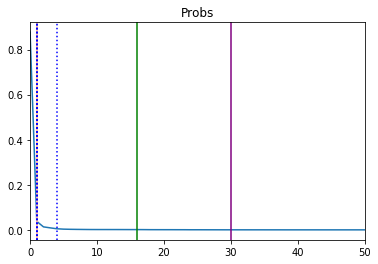

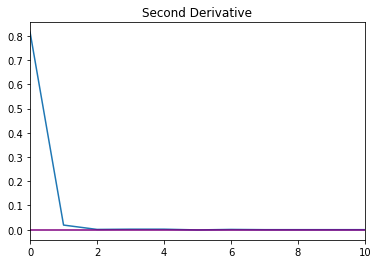

natural tail is at: 66
neg inds [ 0  3  5  7  9 11 12 16 24 64]
 neg weighted mean tail 4
pos inds [ 1  2  4  6  8 10 13 17 25 65]
weights [0.2468354  0.6392405  0.00632912 0.06962025 0.00632912 0.00632912
 0.00632912 0.00632911 0.00632911 0.00632911]
pos weighted mean tail 3
combo tail is:  4
threshold: 0.25 tail id: 2
threshold: 0.75 tail id: 3
threshold: 0.9 tail id: 7
threshold: 0.95 tail id: 9
threshold: 0.99 tail id: 26


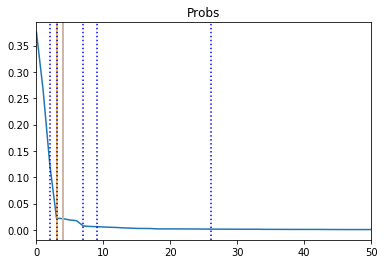

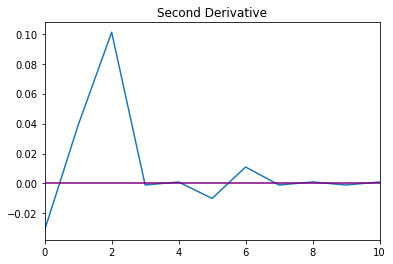

natural tail is at: 107
neg inds [  2   6   9  10  15  18  20  23  28  35  48 105]
 neg weighted mean tail 14
pos inds [  0   1   3   4   5   7   8  11  12  13  14  16  19  21  24  29  36  49
 106]
weights [5.1020408e-01 2.1768704e-01 3.4013595e-02 5.4421771e-02 1.3605443e-02
 5.4421771e-02 2.0408165e-02 2.7210873e-02 6.8027214e-03 6.3355272e-09
 6.8027154e-03 6.8027214e-03 6.8027214e-03 6.8027214e-03 6.8027182e-03
 6.8027214e-03 6.8027200e-03 6.8027209e-03 6.8027209e-03]
pos weighted mean tail 4
combo tail is:  6
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 7
threshold: 0.9 tail id: 13
threshold: 0.95 tail id: 25
threshold: 0.99 tail id: 106


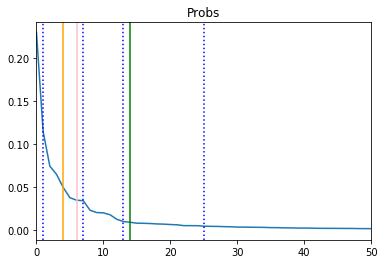

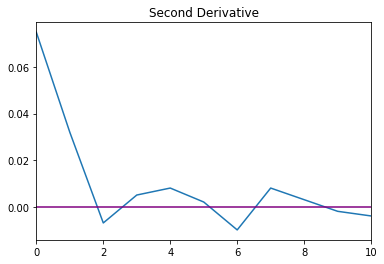

natural tail is at: 9
neg inds [2 7]
 neg weighted mean tail 5
pos inds [0 1 3 8]
weights [0.98078984 0.01600854 0.00213447 0.00106724]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


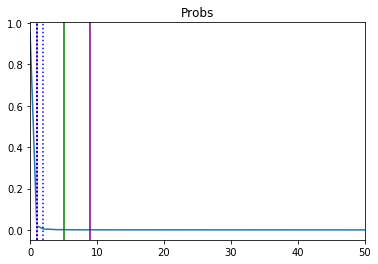

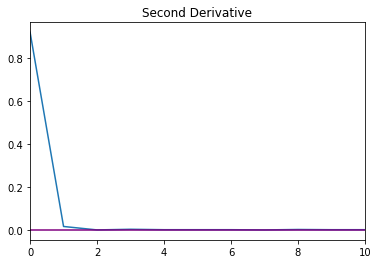

natural tail is at: 53
neg inds [ 4  7 11 19 51]
 neg weighted mean tail 19
pos inds [ 0  1  2  3  5  6  8 12 20 52]
weights [0.72957206 0.22762649 0.02918289 0.00194552 0.00194553 0.00194552
 0.00194553 0.00194553 0.00194553 0.00194553]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 12


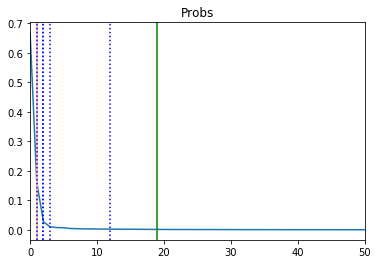

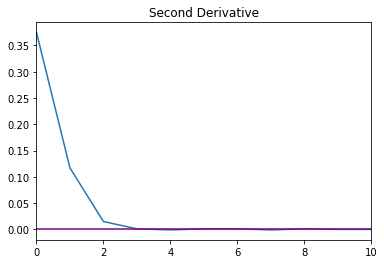

natural tail is at: 46
neg inds [ 2  4  5  7 11 14 19 26 44]
 neg weighted mean tail 9
pos inds [ 0  1  3  6  8 10 12 13 15 20 27 45]
weights [9.4625419e-01 1.6286619e-03 3.4201957e-02 6.5146596e-03 1.6286634e-03
 1.6286649e-03 7.5840606e-10 1.6286641e-03 1.6286649e-03 1.6286644e-03
 1.6286647e-03 1.6286647e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 16


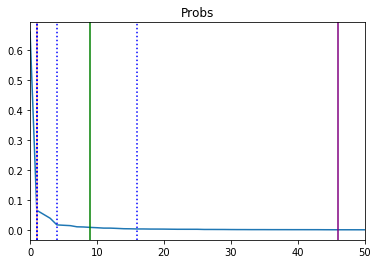

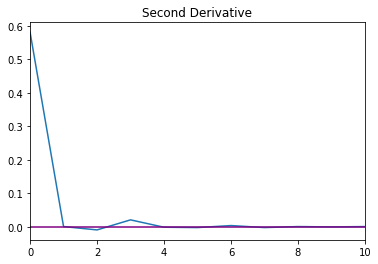

natural tail is at: 58
neg inds [ 2  5  8 10 15 30 56]
 neg weighted mean tail 12
pos inds [ 0  1  3  6  7  9 11 16 17 31 57]
weights [6.3053107e-01 3.3407080e-01 1.7699115e-02 4.4247778e-03 2.2123898e-03
 2.2123898e-03 2.2123889e-03 5.1511206e-10 2.2123894e-03 2.2123896e-03
 2.2123896e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 18


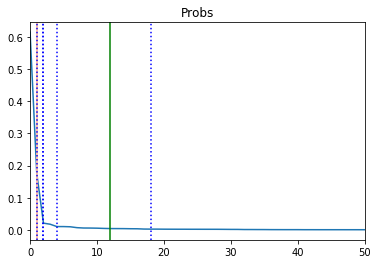

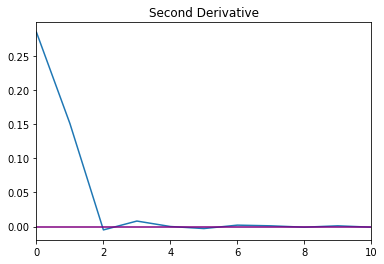

natural tail is at: 23
neg inds [ 3  8 21]
 neg weighted mean tail 11
pos inds [ 0  1  2  4  5  9 22]
weights [0.97970694 0.01127396 0.00450958 0.0011274  0.0011274  0.0011274
 0.0011274 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


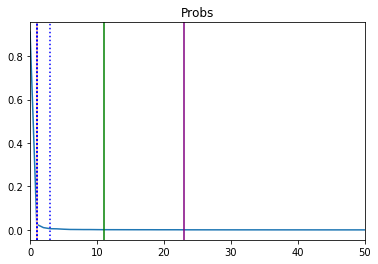

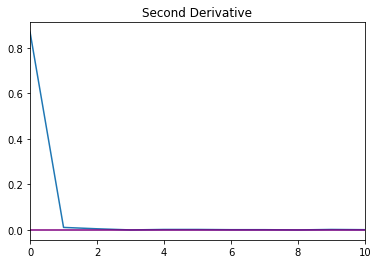

natural tail is at: 38
neg inds [ 1  3  6  8 16 36]
 neg weighted mean tail 4
pos inds [ 0  2  4  5  7  9 17 37]
weights [0.9092308  0.08153848 0.00153846 0.00153846 0.00153846 0.00153846
 0.00153846 0.00153846]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 8


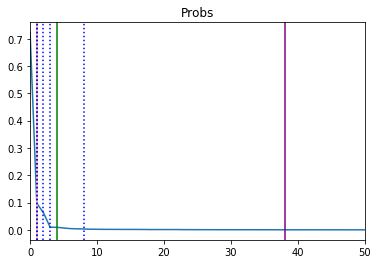

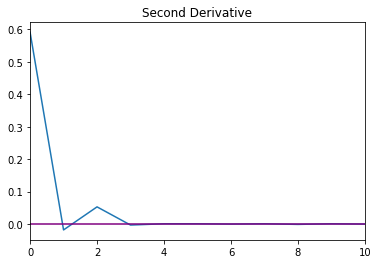

natural tail is at: 48
neg inds [ 4  7  8 12 14 17 25 46]
 neg weighted mean tail 18
pos inds [ 0  1  2  3  5 11 13 15 18 26 47]
weights [0.8670989  0.11507294 0.00162075 0.00486224 0.00162075 0.00162075
 0.00162075 0.00162075 0.00162075 0.00162075 0.00162075]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


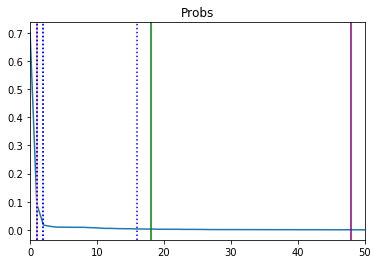

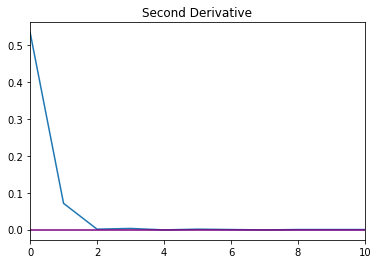

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


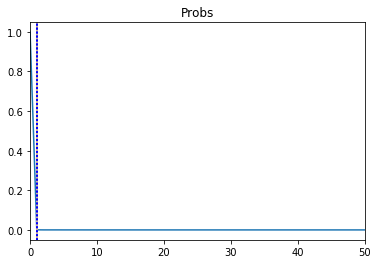

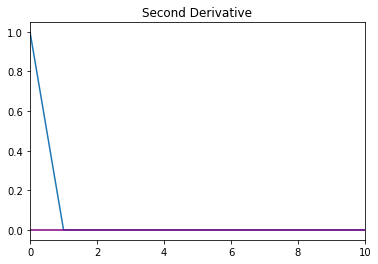

natural tail is at: 14
neg inds [ 3 12]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 13]
weights [0.9849301  0.00968784 0.00215285 0.00215285 0.00107643]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


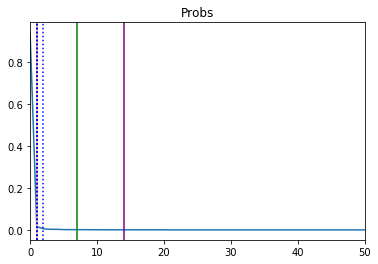

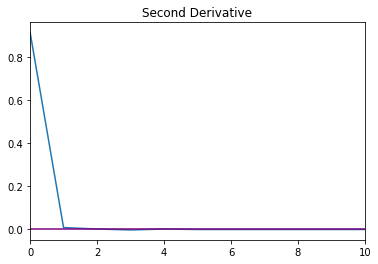

natural tail is at: 23
neg inds [ 1  5 21]
 neg weighted mean tail 10
pos inds [ 0  2  3  4  6 22]
weights [0.99232465 0.00109649 0.00219298 0.00219298 0.00109649 0.00109649]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


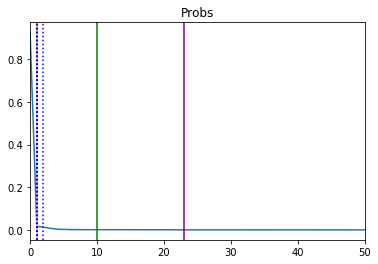

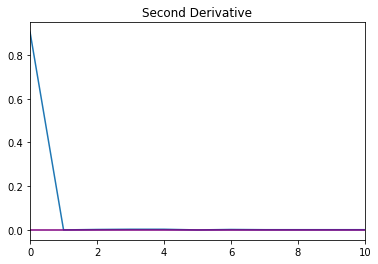

natural tail is at: 46
neg inds [ 4  7 11 12 14 21 44]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  5  8 13 15 22 45]
weights [0.5934066  0.38241762 0.00439561 0.0043956  0.0021978  0.00439561
 0.0021978  0.0021978  0.0021978  0.0021978 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


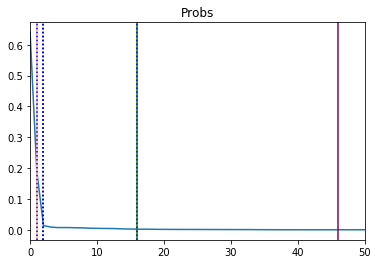

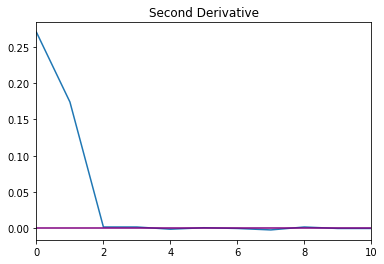

natural tail is at: 17
neg inds [ 4 15]
 neg weighted mean tail 15
pos inds [ 0  1  2  3  5 16]
weights [9.9357605e-01 3.2119912e-03 4.9856669e-10 1.0706638e-03 1.0706639e-03
 1.0706639e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


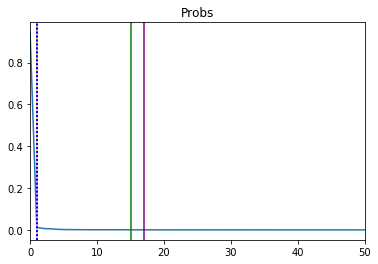

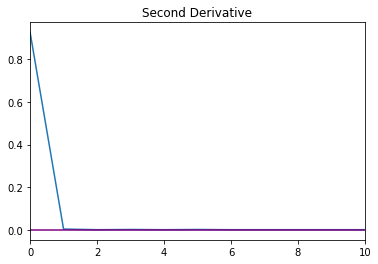

natural tail is at: 25
neg inds [ 1  6 23]
 neg weighted mean tail 8
pos inds [ 0  2  3  4  7 24]
weights [0.984091   0.01136364 0.00113636 0.00113636 0.00113636 0.00113636]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


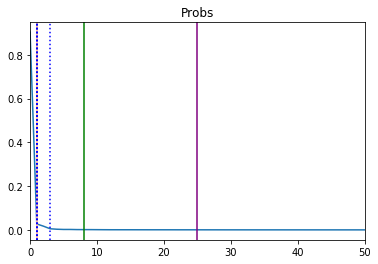

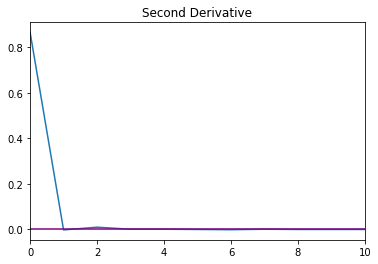

natural tail is at: 40
neg inds [ 2  6 10 14 38]
 neg weighted mean tail 6
pos inds [ 0  1  3  4  5  7 11 15 39]
weights [0.8967468  0.07637906 0.01697312 0.00282886 0.00141443 0.00141443
 0.00141443 0.00141443 0.00141443]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 7


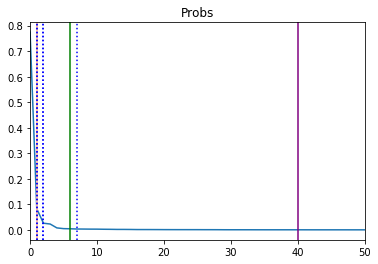

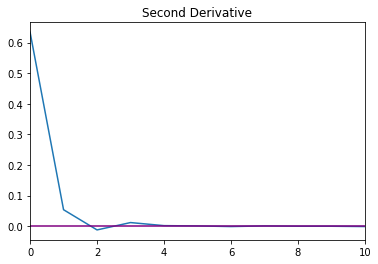

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


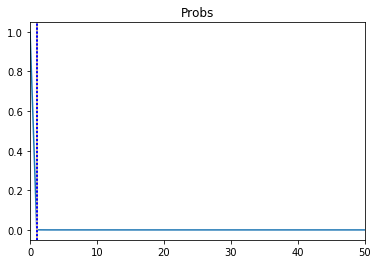

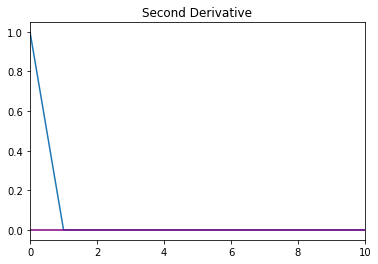

natural tail is at: 15
neg inds [ 1 13]
 neg weighted mean tail 7
pos inds [ 0  2  3 14]
weights [0.99687827 0.00104058 0.00104058 0.00104058]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


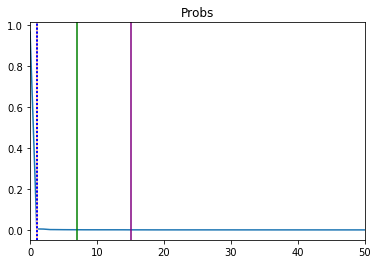

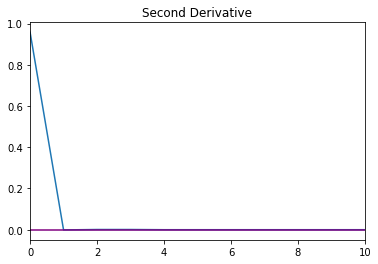

natural tail is at: 12
neg inds [ 3 10]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 11]
weights [0.99169266 0.00519211 0.00103842 0.00103842 0.00103842]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


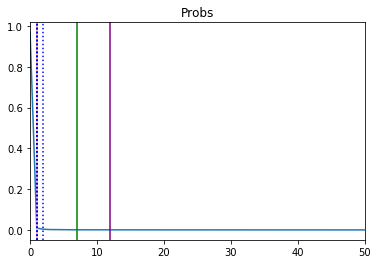

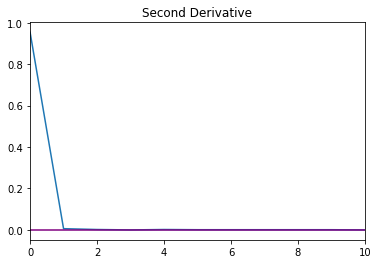

natural tail is at: 30
neg inds [ 5 13 28]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  4  6 14 29]
weights [0.9679335  0.02256532 0.00118765 0.0023753  0.0023753  0.00118765
 0.00118765 0.00118765]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 4


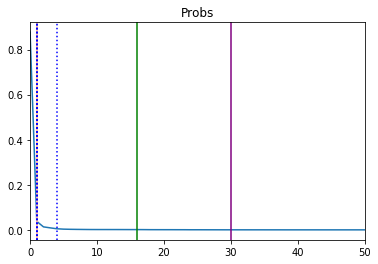

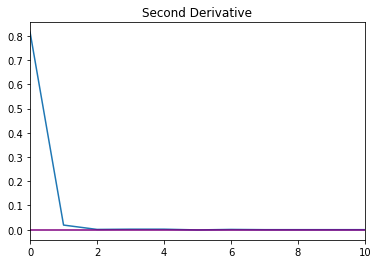

natural tail is at: 66
neg inds [ 0  3  5  7  9 11 12 16 24 64]
 neg weighted mean tail 4
pos inds [ 1  2  4  6  8 10 13 17 25 65]
weights [0.2468354  0.6392405  0.00632912 0.06962025 0.00632912 0.00632912
 0.00632912 0.00632911 0.00632911 0.00632911]
pos weighted mean tail 3
combo tail is:  4
threshold: 0.25 tail id: 2
threshold: 0.75 tail id: 3
threshold: 0.9 tail id: 7
threshold: 0.95 tail id: 9
threshold: 0.99 tail id: 26


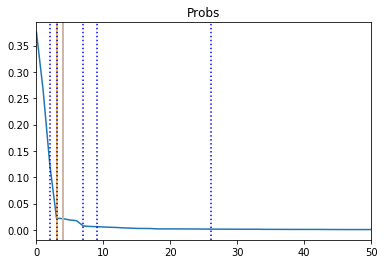

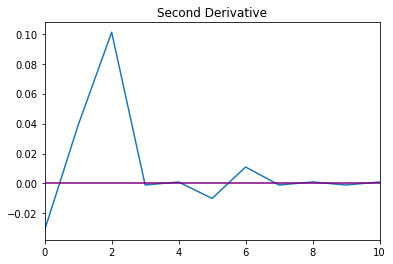

natural tail is at: 107
neg inds [  2   6   9  10  15  18  20  23  28  35  48 105]
 neg weighted mean tail 14
pos inds [  0   1   3   4   5   7   8  11  12  13  14  16  19  21  24  29  36  49
 106]
weights [5.1020408e-01 2.1768704e-01 3.4013595e-02 5.4421771e-02 1.3605443e-02
 5.4421771e-02 2.0408165e-02 2.7210873e-02 6.8027214e-03 6.3355272e-09
 6.8027154e-03 6.8027214e-03 6.8027214e-03 6.8027214e-03 6.8027182e-03
 6.8027214e-03 6.8027200e-03 6.8027209e-03 6.8027209e-03]
pos weighted mean tail 4
combo tail is:  6
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 7
threshold: 0.9 tail id: 13
threshold: 0.95 tail id: 25
threshold: 0.99 tail id: 106


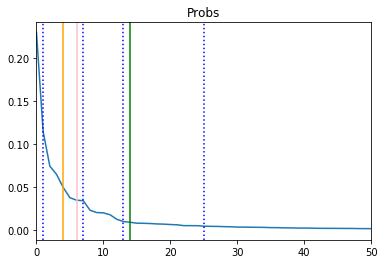

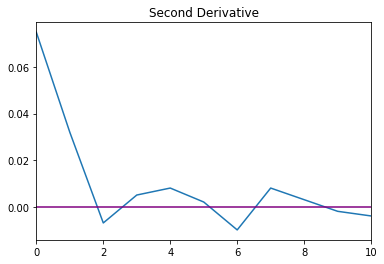

natural tail is at: 9
neg inds [2 7]
 neg weighted mean tail 5
pos inds [0 1 3 8]
weights [0.98078984 0.01600854 0.00213447 0.00106724]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


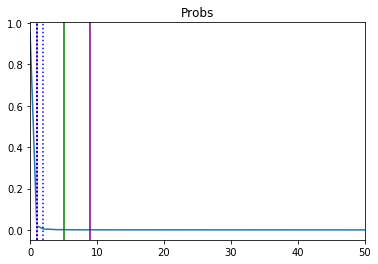

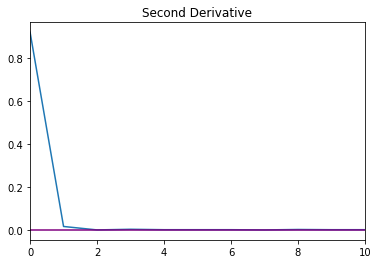

natural tail is at: 53
neg inds [ 4  7 11 19 51]
 neg weighted mean tail 19
pos inds [ 0  1  2  3  5  6  8 12 20 52]
weights [0.72957206 0.22762649 0.02918289 0.00194552 0.00194553 0.00194552
 0.00194553 0.00194553 0.00194553 0.00194553]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 12


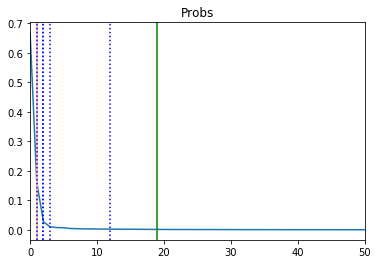

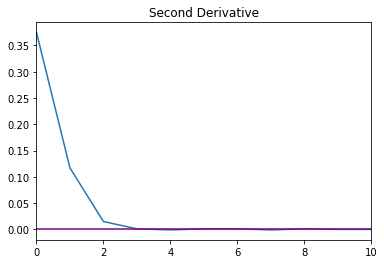

natural tail is at: 46
neg inds [ 2  4  5  7 11 14 19 26 44]
 neg weighted mean tail 9
pos inds [ 0  1  3  6  8 10 12 13 15 20 27 45]
weights [9.4625419e-01 1.6286619e-03 3.4201957e-02 6.5146596e-03 1.6286634e-03
 1.6286649e-03 7.5840606e-10 1.6286641e-03 1.6286649e-03 1.6286644e-03
 1.6286647e-03 1.6286647e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 16


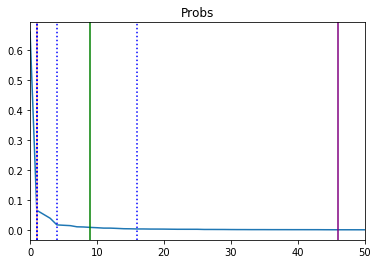

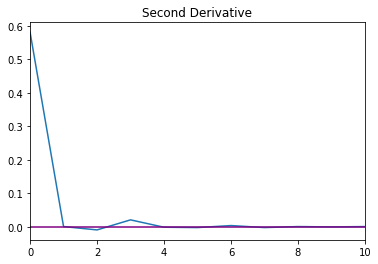

natural tail is at: 58
neg inds [ 2  5  8 10 15 30 56]
 neg weighted mean tail 12
pos inds [ 0  1  3  6  7  9 11 16 17 31 57]
weights [6.3053107e-01 3.3407080e-01 1.7699115e-02 4.4247778e-03 2.2123898e-03
 2.2123898e-03 2.2123889e-03 5.1511206e-10 2.2123894e-03 2.2123896e-03
 2.2123896e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 18


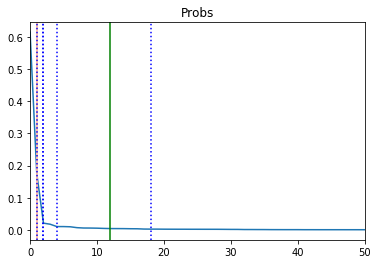

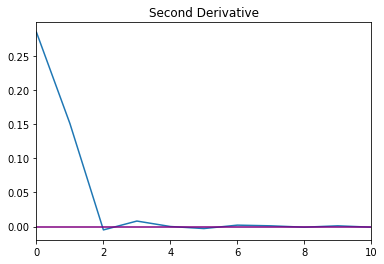

natural tail is at: 23
neg inds [ 3  8 21]
 neg weighted mean tail 11
pos inds [ 0  1  2  4  5  9 22]
weights [0.97970694 0.01127396 0.00450958 0.0011274  0.0011274  0.0011274
 0.0011274 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


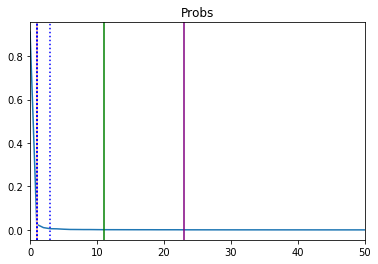

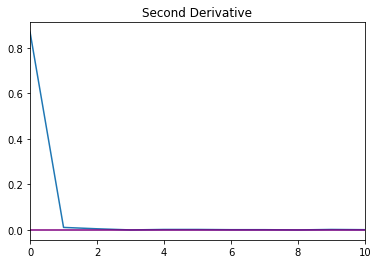

natural tail is at: 38
neg inds [ 1  3  6  8 16 36]
 neg weighted mean tail 4
pos inds [ 0  2  4  5  7  9 17 37]
weights [0.9092308  0.08153848 0.00153846 0.00153846 0.00153846 0.00153846
 0.00153846 0.00153846]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 8


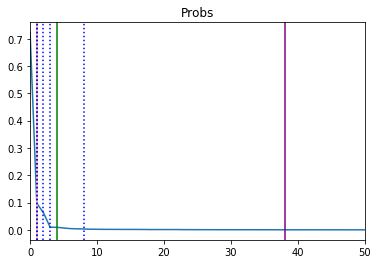

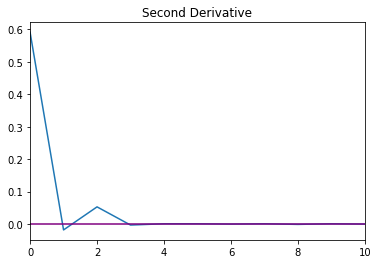

natural tail is at: 48
neg inds [ 4  7  8 12 14 17 25 46]
 neg weighted mean tail 18
pos inds [ 0  1  2  3  5 11 13 15 18 26 47]
weights [0.8670989  0.11507294 0.00162075 0.00486224 0.00162075 0.00162075
 0.00162075 0.00162075 0.00162075 0.00162075 0.00162075]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


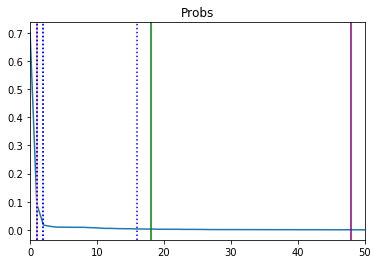

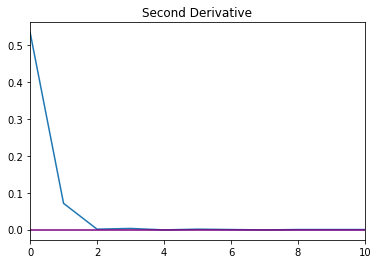

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


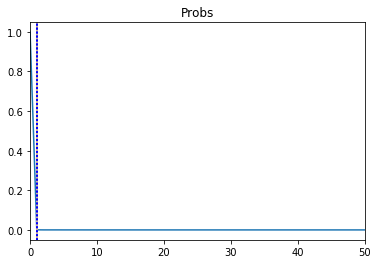

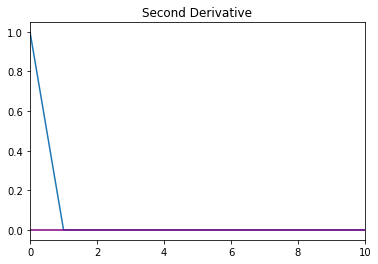

natural tail is at: 14
neg inds [ 3 12]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 13]
weights [0.9849301  0.00968784 0.00215285 0.00215285 0.00107643]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


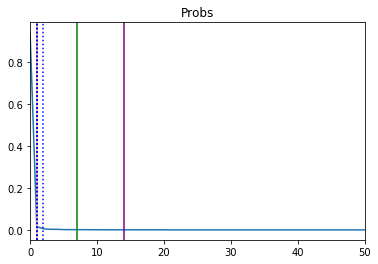

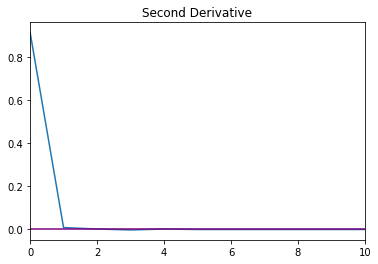

natural tail is at: 23
neg inds [ 1  5 21]
 neg weighted mean tail 10
pos inds [ 0  2  3  4  6 22]
weights [0.99232465 0.00109649 0.00219298 0.00219298 0.00109649 0.00109649]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


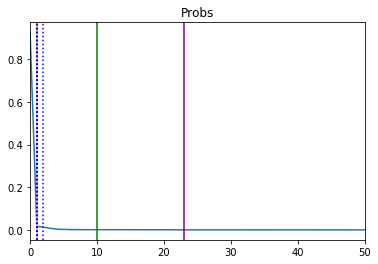

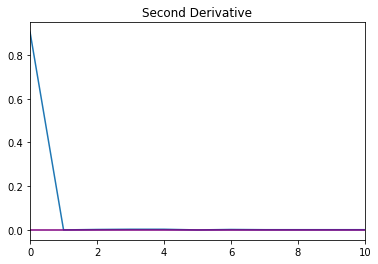

natural tail is at: 46
neg inds [ 4  7 11 12 14 21 44]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  5  8 13 15 22 45]
weights [0.5934066  0.38241762 0.00439561 0.0043956  0.0021978  0.00439561
 0.0021978  0.0021978  0.0021978  0.0021978 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


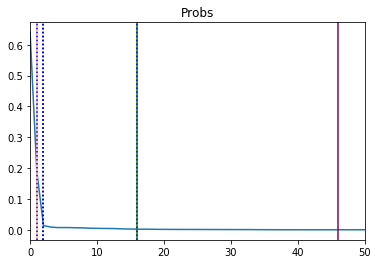

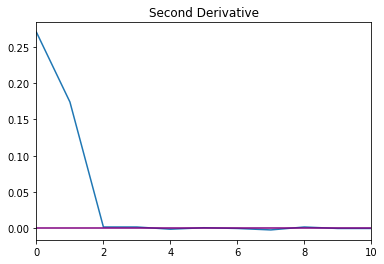

natural tail is at: 17
neg inds [ 4 15]
 neg weighted mean tail 15
pos inds [ 0  1  2  3  5 16]
weights [9.9357605e-01 3.2119912e-03 4.9856669e-10 1.0706638e-03 1.0706639e-03
 1.0706639e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


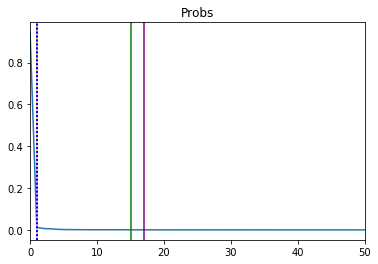

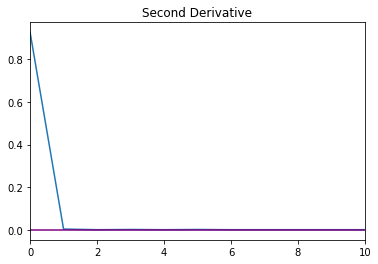

natural tail is at: 25
neg inds [ 1  6 23]
 neg weighted mean tail 8
pos inds [ 0  2  3  4  7 24]
weights [0.984091   0.01136364 0.00113636 0.00113636 0.00113636 0.00113636]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


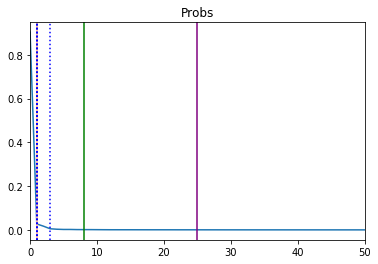

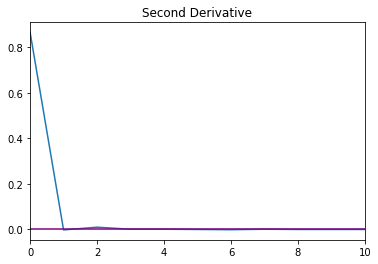

natural tail is at: 40
neg inds [ 2  6 10 14 38]
 neg weighted mean tail 6
pos inds [ 0  1  3  4  5  7 11 15 39]
weights [0.8967468  0.07637906 0.01697312 0.00282886 0.00141443 0.00141443
 0.00141443 0.00141443 0.00141443]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 7


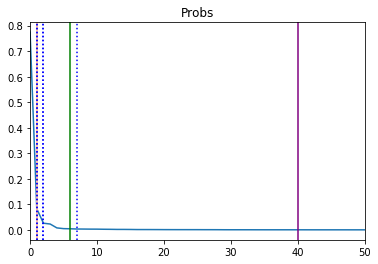

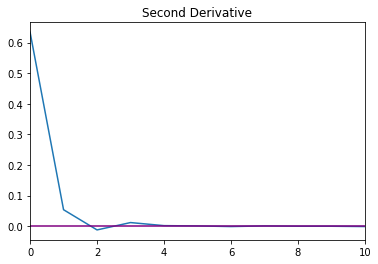

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


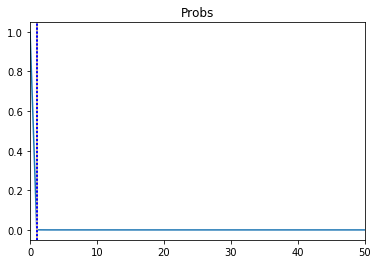

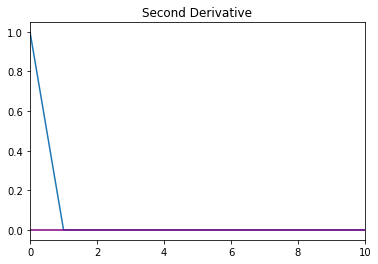

natural tail is at: 15
neg inds [ 1 13]
 neg weighted mean tail 7
pos inds [ 0  2  3 14]
weights [0.99687827 0.00104058 0.00104058 0.00104058]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


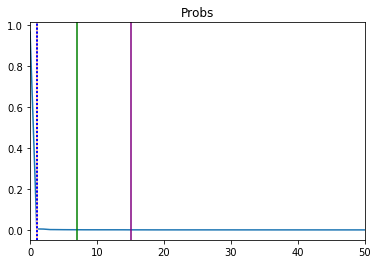

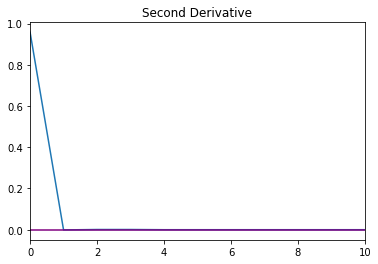

natural tail is at: 12
neg inds [ 3 10]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 11]
weights [0.99169266 0.00519211 0.00103842 0.00103842 0.00103842]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


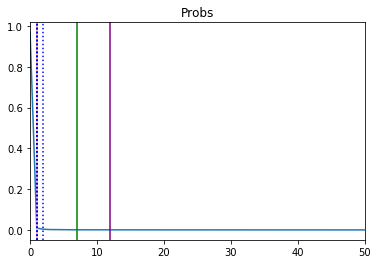

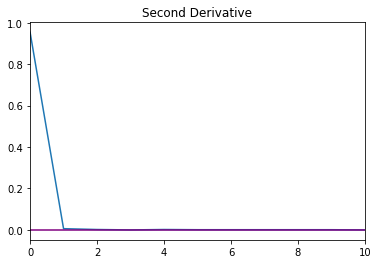

natural tail is at: 30
neg inds [ 5 13 28]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  4  6 14 29]
weights [0.9679335  0.02256532 0.00118765 0.0023753  0.0023753  0.00118765
 0.00118765 0.00118765]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 4


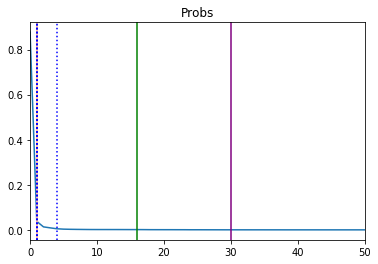

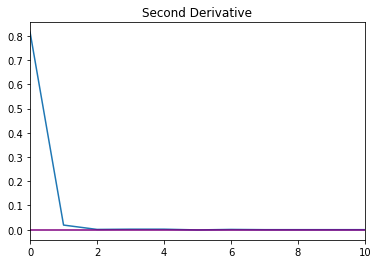

natural tail is at: 66
neg inds [ 0  3  5  7  9 11 12 16 24 64]
 neg weighted mean tail 4
pos inds [ 1  2  4  6  8 10 13 17 25 65]
weights [0.2468354  0.6392405  0.00632912 0.06962025 0.00632912 0.00632912
 0.00632912 0.00632911 0.00632911 0.00632911]
pos weighted mean tail 3
combo tail is:  4
threshold: 0.25 tail id: 2
threshold: 0.75 tail id: 3
threshold: 0.9 tail id: 7
threshold: 0.95 tail id: 9
threshold: 0.99 tail id: 26


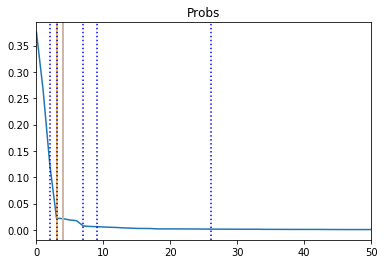

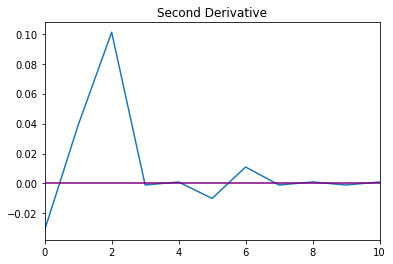

natural tail is at: 107
neg inds [  2   6   9  10  15  18  20  23  28  35  48 105]
 neg weighted mean tail 14
pos inds [  0   1   3   4   5   7   8  11  12  13  14  16  19  21  24  29  36  49
 106]
weights [5.1020408e-01 2.1768704e-01 3.4013595e-02 5.4421771e-02 1.3605443e-02
 5.4421771e-02 2.0408165e-02 2.7210873e-02 6.8027214e-03 6.3355272e-09
 6.8027154e-03 6.8027214e-03 6.8027214e-03 6.8027214e-03 6.8027182e-03
 6.8027214e-03 6.8027200e-03 6.8027209e-03 6.8027209e-03]
pos weighted mean tail 4
combo tail is:  6
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 7
threshold: 0.9 tail id: 13
threshold: 0.95 tail id: 25
threshold: 0.99 tail id: 106


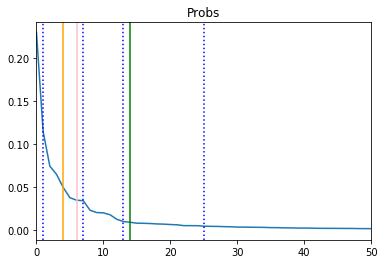

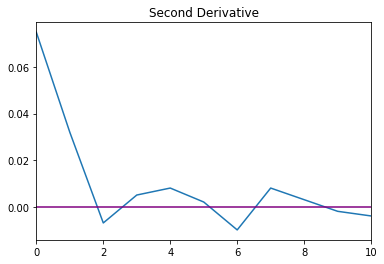

natural tail is at: 9
neg inds [2 7]
 neg weighted mean tail 5
pos inds [0 1 3 8]
weights [0.98078984 0.01600854 0.00213447 0.00106724]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


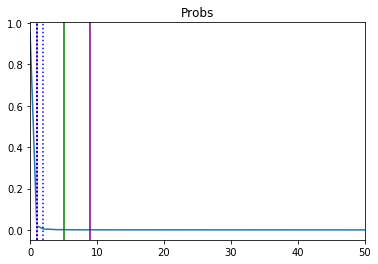

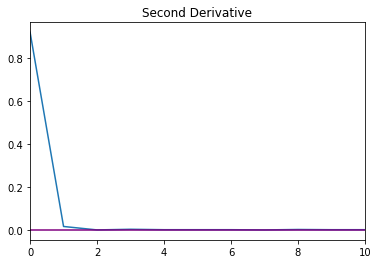

natural tail is at: 53
neg inds [ 4  7 11 19 51]
 neg weighted mean tail 19
pos inds [ 0  1  2  3  5  6  8 12 20 52]
weights [0.72957206 0.22762649 0.02918289 0.00194552 0.00194553 0.00194552
 0.00194553 0.00194553 0.00194553 0.00194553]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 12


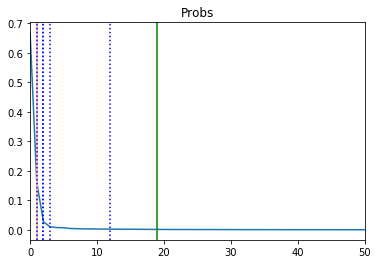

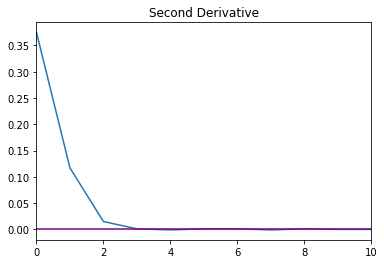

natural tail is at: 46
neg inds [ 2  4  5  7 11 14 19 26 44]
 neg weighted mean tail 9
pos inds [ 0  1  3  6  8 10 12 13 15 20 27 45]
weights [9.4625419e-01 1.6286619e-03 3.4201957e-02 6.5146596e-03 1.6286634e-03
 1.6286649e-03 7.5840606e-10 1.6286641e-03 1.6286649e-03 1.6286644e-03
 1.6286647e-03 1.6286647e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 16


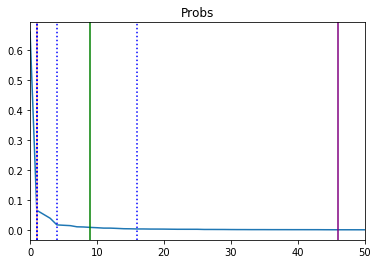

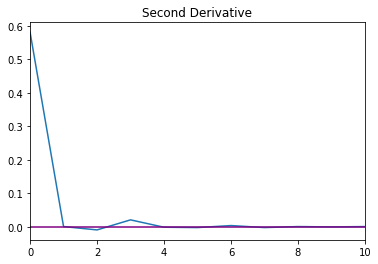

natural tail is at: 58
neg inds [ 2  5  8 10 15 30 56]
 neg weighted mean tail 12
pos inds [ 0  1  3  6  7  9 11 16 17 31 57]
weights [6.3053107e-01 3.3407080e-01 1.7699115e-02 4.4247778e-03 2.2123898e-03
 2.2123898e-03 2.2123889e-03 5.1511206e-10 2.2123894e-03 2.2123896e-03
 2.2123896e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 4
threshold: 0.99 tail id: 18


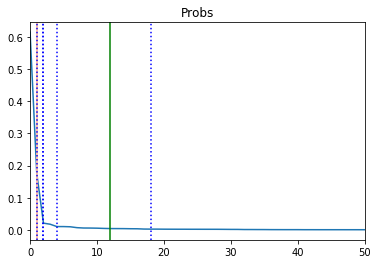

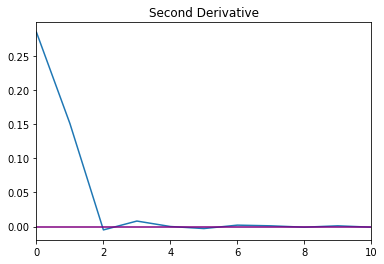

natural tail is at: 23
neg inds [ 3  8 21]
 neg weighted mean tail 11
pos inds [ 0  1  2  4  5  9 22]
weights [0.97970694 0.01127396 0.00450958 0.0011274  0.0011274  0.0011274
 0.0011274 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


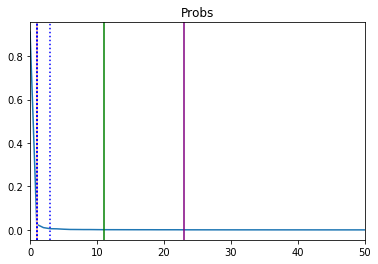

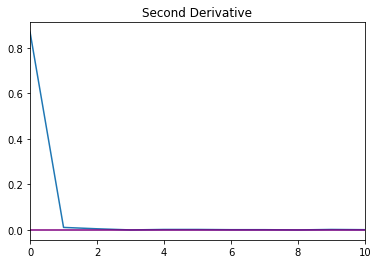

natural tail is at: 38
neg inds [ 1  3  6  8 16 36]
 neg weighted mean tail 4
pos inds [ 0  2  4  5  7  9 17 37]
weights [0.9092308  0.08153848 0.00153846 0.00153846 0.00153846 0.00153846
 0.00153846 0.00153846]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 3
threshold: 0.99 tail id: 8


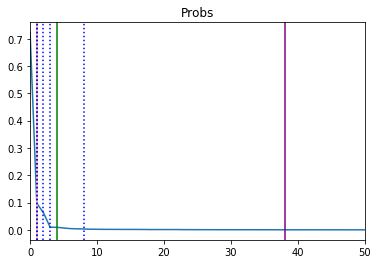

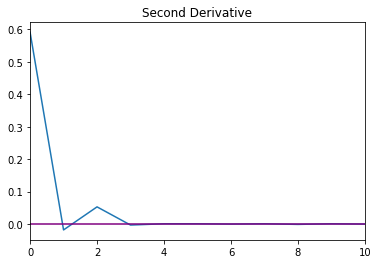

natural tail is at: 48
neg inds [ 4  7  8 12 14 17 25 46]
 neg weighted mean tail 18
pos inds [ 0  1  2  3  5 11 13 15 18 26 47]
weights [0.8670989  0.11507294 0.00162075 0.00486224 0.00162075 0.00162075
 0.00162075 0.00162075 0.00162075 0.00162075 0.00162075]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


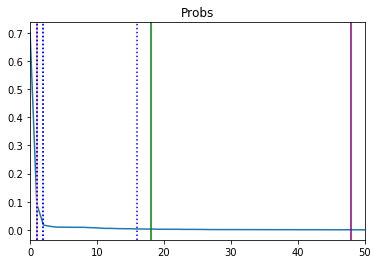

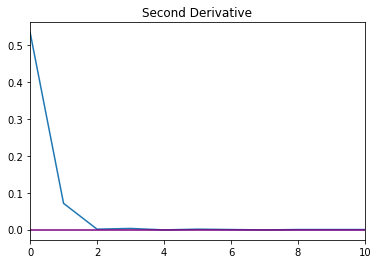

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


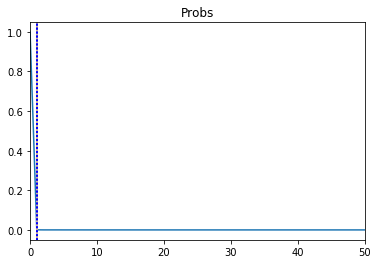

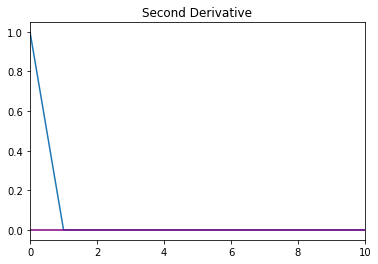

natural tail is at: 14
neg inds [ 3 12]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 13]
weights [0.9849301  0.00968784 0.00215285 0.00215285 0.00107643]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


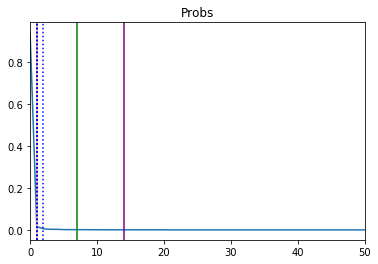

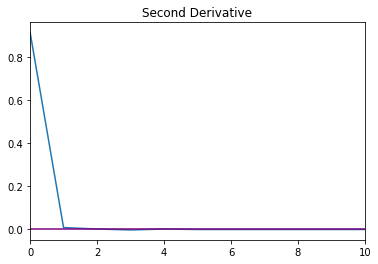

natural tail is at: 23
neg inds [ 1  5 21]
 neg weighted mean tail 10
pos inds [ 0  2  3  4  6 22]
weights [0.99232465 0.00109649 0.00219298 0.00219298 0.00109649 0.00109649]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


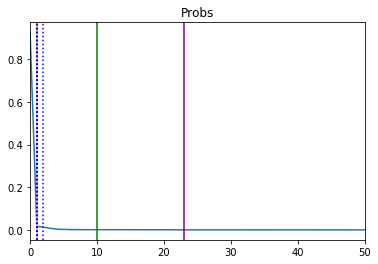

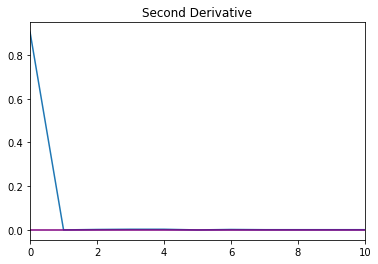

natural tail is at: 46
neg inds [ 4  7 11 12 14 21 44]
 neg weighted mean tail 16
pos inds [ 0  1  2  3  5  8 13 15 22 45]
weights [0.5934066  0.38241762 0.00439561 0.0043956  0.0021978  0.00439561
 0.0021978  0.0021978  0.0021978  0.0021978 ]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 2
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 16


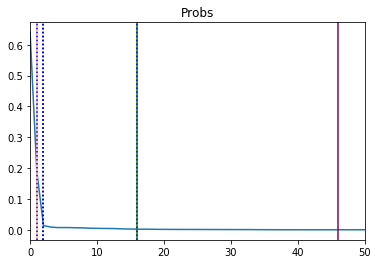

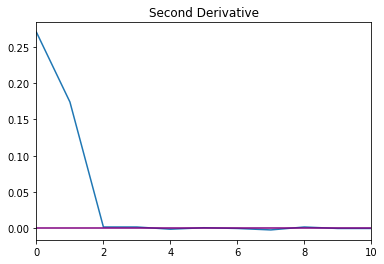

natural tail is at: 17
neg inds [ 4 15]
 neg weighted mean tail 15
pos inds [ 0  1  2  3  5 16]
weights [9.9357605e-01 3.2119912e-03 4.9856669e-10 1.0706638e-03 1.0706639e-03
 1.0706639e-03]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


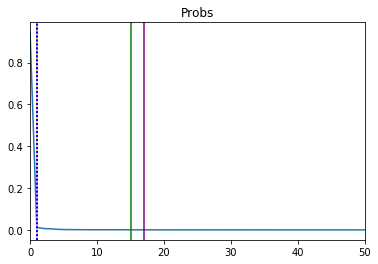

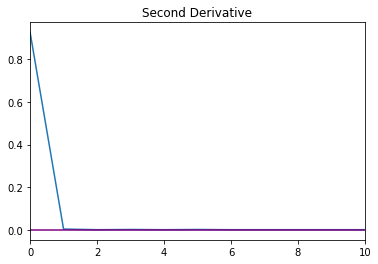

natural tail is at: 25
neg inds [ 1  6 23]
 neg weighted mean tail 8
pos inds [ 0  2  3  4  7 24]
weights [0.984091   0.01136364 0.00113636 0.00113636 0.00113636 0.00113636]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 3


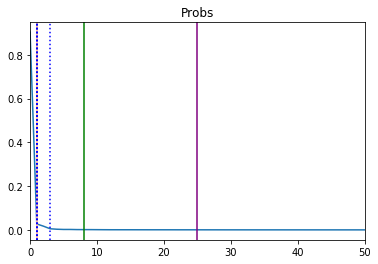

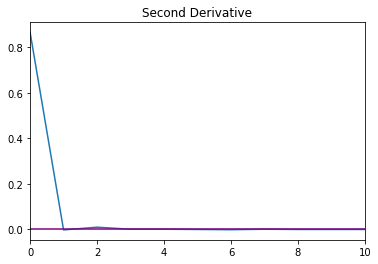

natural tail is at: 40
neg inds [ 2  6 10 14 38]
 neg weighted mean tail 6
pos inds [ 0  1  3  4  5  7 11 15 39]
weights [0.8967468  0.07637906 0.01697312 0.00282886 0.00141443 0.00141443
 0.00141443 0.00141443 0.00141443]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 2
threshold: 0.95 tail id: 2
threshold: 0.99 tail id: 7


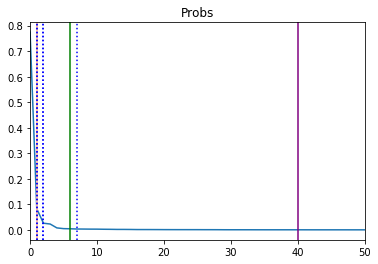

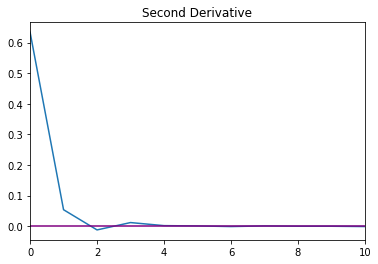

natural tail is at: 1
neg inds []
 neg weighted mean tail 1
pos inds [0]
weights [1.]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


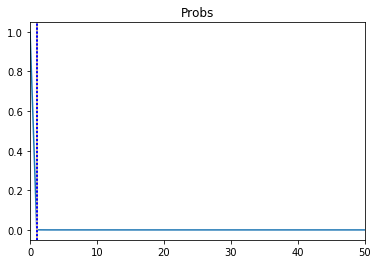

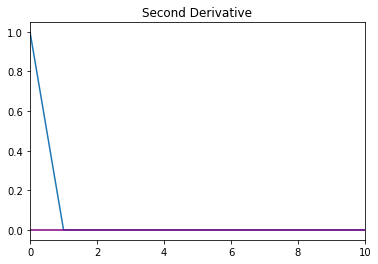

natural tail is at: 15
neg inds [ 1 13]
 neg weighted mean tail 7
pos inds [ 0  2  3 14]
weights [0.99687827 0.00104058 0.00104058 0.00104058]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 1


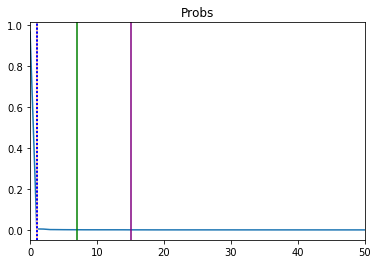

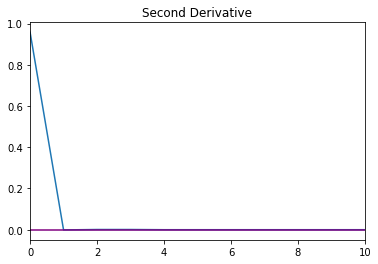

natural tail is at: 12
neg inds [ 3 10]
 neg weighted mean tail 7
pos inds [ 0  1  2  4 11]
weights [0.99169266 0.00519211 0.00103842 0.00103842 0.00103842]
pos weighted mean tail 1
combo tail is:  1
threshold: 0.25 tail id: 1
threshold: 0.75 tail id: 1
threshold: 0.9 tail id: 1
threshold: 0.95 tail id: 1
threshold: 0.99 tail id: 2


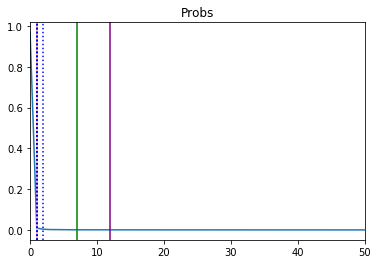

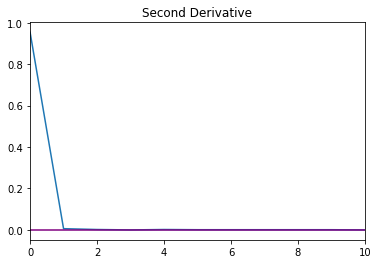

'\nI see a tail as both a change (drop off) and being closest \nto the right hand side. problem is that the right hand side is lower bounded \nand will naturally have peaks that \narent as tall. \nThis rate of change is relative. but different curves could be above and below the threshold. \n\nGet a distribution of the peaks (or drops, need to see how the drops does and then pick from this. ) this would be more meaningful than taking the "third drop"\nfor example. but how to do this computationally efficiently?? cum sum up all of the negative secondary derivatives and find the one above a certain value. means 2 more \nsubtraction operations than nucleus to get the gradient and then a renormalization. \n\nwhat about a weighted average with the normalized heights of each of the mini tails? \n\nbias towards being closer to the start of the generation. \n\nrounding at the 3rd decimal is so small it just makes a clearer signal and allows me to set the threshold to be >0. \n\nThe combo and t

In [75]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

def ema_eff(alpha,  vals, perc_acc=0.99 ):
    k = int(np.log(1-perc_acc)/np.log(1-alpha)) # this should be calculated at the start not in the loop!! 
    print('size of K for EMA', k)
    
    if k>vals.shape[0]: # CHECK THIS SHAPE MEASUREMENT
        k = vals.shape[0]
    
    # have something to check the tail id is less than the window size. 
    
    window_weights = (1-alpha)**np.arange(0,k)
    p = k-1
    # THIS CAN BE DONE IN A BATCH V EFFICIENTLY
    out = torch.nn.functional.conv1d(torch.from_numpy(vals).unsqueeze(0).unsqueeze(1).double(),torch.from_numpy(window_weights).unsqueeze(0).unsqueeze(1), padding=p )
    out = alpha*out[0,0,p:]
    print(out.shape)
    
    return out.numpy()
    
    
alpha = 0.05 #lower the alpha, smoother the curve and more weight placed on previous observations. 
eff_alpha = 0.05

for b in range(all_logits.shape[0]):
    for i in range(20): #(all_logits.shape[2]):
        
        all_tails = []
        
        sps = softmax(-np.sort(-all_logits[2, :, i])) 
        
        sps_round=np.around(sps,3) # so that I can have >0 rather than a set threshold. 
        
        #finding the tail without any alpha first
        first = sps_round[1:] - sps_round[:-1]
        second = first[1:] - first[:-1]
        tail_id = second.shape[0]-np.argmax(np.flip(second)>0) # gradient calc fix. 
        print('natural tail is at:', tail_id)
        all_tails.append(tail_id)
        
        sec_mask = second<0
        sec_indices = np.arange(len(second))[sec_mask]
        sec = -second[sec_mask]
        sec_weights = sec/sec.sum()
        neg_weighted_mean_tail = int(sec_indices@sec_weights)+1
        print('neg inds', sec_indices)
        print(' neg weighted mean tail', neg_weighted_mean_tail)
        
        sec_mask = second>0
        sec_indices = np.arange(len(second))[sec_mask]
        print('pos inds', sec_indices)
        sec = -second[sec_mask]
        sec_weights = sec/sec.sum()
        print('weights', sec_weights)
        pos_weighted_mean_tail = int(sec_indices@sec_weights)+1 # this is the same as applying a ceiling to it. 
        
        print('pos weighted mean tail', pos_weighted_mean_tail)
        
        only_pos = np.abs(second)
        sec_indices = np.arange(len(second))
        sec_weights = only_pos/only_pos.sum()
        combo_tail = int(sec_indices@sec_weights)+1
        
        # do cum sum for the combo (seems to be more theoretically robust)
        thresholds = [0.25, 0.75, 0.9, 0.95, 0.99]
        thresh_tails = []
        for t in thresholds: 
            thresh_tails.append( np.argmax(np.cumsum(sec_weights)>t)+1 )
        
        print('combo tail is: ', combo_tail)
        
        plt.plot(np.arange(0,len(sps)),sps)
        plt.axvline(tail_id, color='purple', linestyle='solid')
        plt.axvline(pos_weighted_mean_tail, color='orange', linestyle='solid')
        plt.axvline(neg_weighted_mean_tail, color='green', linestyle='solid')
        plt.axvline(combo_tail, color='pink', linestyle='solid')
        
        for ind, t in enumerate(thresh_tails): 
            print('threshold:', thresholds[ind],'tail id:', t)
            plt.axvline(t, color='blue', linestyle='dotted')
        plt.xlim([0,50])
        plt.title('Probs')
        #plt.title('SMA Plot '+str(window_proportion))
        plt.show()
        
        plt.plot(np.arange(0,len(second)),second)
        plt.axhline(0.00001, color='purple', linestyle='solid')
        plt.xlim([0,10])
        plt.title('Second Derivative')
        #plt.title('SMA Plot '+str(window_proportion))
        plt.show()
        print('==============')
        print('==============')
        
        
'''
I see a tail as both a change (drop off) and being closest 
to the right hand side. problem is that the right hand side is lower bounded 
and will naturally have peaks that 
arent as tall. 
This rate of change is relative. but different curves could be above and below the threshold. 

Get a distribution of the peaks (or drops, need to see how the drops does and then pick from this. ) this would be more meaningful than taking the "third drop"
for example. but how to do this computationally efficiently?? cum sum up all of the negative secondary derivatives and find the one above a certain value. means 2 more 
subtraction operations than nucleus to get the gradient and then a renormalization. 

what about a weighted average with the normalized heights of each of the mini tails? 

bias towards being closer to the start of the generation. 

rounding at the 3rd decimal is so small it just makes a clearer signal and allows me to set the threshold to be >0. 

The combo and the 90% of the combo look to be very good. one is a bit more generous that the other. I should play with higher than 90 too as the cum sum diminishes
from the weaker signals that are further away. 

'''

# No plotting

In [1]:
import pickle
import numpy as np 
import gzip
all_logits = pickle.load(gzip.open('gpt-2_output/all_logitstfs-sampling-type_100-word-prompts_150-gen-length_50-number-of-prompts.pickle.gz', 'rb'))
len(all_logits)

2

In [39]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd

def ema_calc(alpha, vals, reverse=False):
    ema = []
    for i in range(vals.shape[0]):
        if i == 0:
            ema.append(vals[i])
        else: 
            ema.append( (alpha*vals[i]) + ((1-alpha)*ema[i-1]) )
    if reverse:
        return np.flip(np.asarray(ema))
    else:
        return np.asarray(ema)

def nucleus_calc(threshs, vals):
    n_threshs = []
    for t in threshs: 
        n_threshs.append(np.argmax(np.cumsum(vals)>t)+1)
    return n_threshs

def sma_calc(n_prop, n, vals, tail_id, weights_type='linear'):
    window = int(n_prop*tail_id)+1 #int(n*n_prop)+1 #int(n_prop*tail_id)+1 #int(n*n_prop) # should really calculate this and N at the very start. 
    
    if weights_type=='linear':
        weights = np.linspace(1,0,window)/np.linspace(1,0,window).sum()
        #weights = np.linspace(1,0,window)/window
        
    elif weights_type=='log':
        weights=np.logspace(1,0,window)/np.logspace(1,0,window).sum()
        
    elif weights_type=='uniform':
        weights = np.ones((window))*(1/window)
    
    tail_size = vals.shape[0]-tail_id # this is the max size of the window
    
    if window>tail_size:
        #print('window is too large, making it look across the whole tail')
        window=tail_size
    
    #print('window being used:',window)
    sma = vals
    # can apply a convolution here that is not being trained!
    for i in range(0,vals.shape[0]-window):
        sma[i] =  np.sum( vals[i:i+window]*weights ) #np.mean(vals[i:i+window])
    return sma
    
alpha = 1 #lower the alpha, smoother the curve and more weight placed on previous observations. 
#only below 0.1 does it really start to have any effect. 

threshs = [0.1, 0.25, 0.5, 0.75, 0.9] # for the nucleus sampling

N = all_logits[0].shape[1]

nt = [] #pd.DataFrame(columns=[threshs+['tail']])
for meta_b in range(len(all_logits)):
    for b in range(all_logits[meta_b].shape[0]):
        for i in range(all_logits[meta_b].shape[2]):
            sps_pure = softmax(-np.sort(-all_logits[meta_b][b, :, i]))
            sps = softmax(-np.sort(-all_logits[meta_b][b, :, i]))
            indices = np.argsort(-all_logits[meta_b][b, :, i])
            rev_sps = softmax(np.sort(all_logits[meta_b][b, :, i]))

            #finding the tail without any alpha first
            sps_round= np.around(sps,2) # ROUNDING UP THE SPS!
            first = sps_round[1:] - sps_round[:-1]
            second = first[1:] - first[:-1]
            tail_id = second.shape[0]-np.argmax(np.flip(second)>0.001)
            #tail_id = second.shape[0]-np.argmax(np.flip(second)>0.001) # still want the first one that hits

            # now looking for better tails, going to use a SMA with differnet proportions of the N as a window


            sma_tails = []
            percentage_of_tail =[0.5, 0.9, 1] #, 1.5, 3] #[ 2, 2.5,3,3.5]#[0.1, 0.25, 0.5, 0.75, 0.9]

            #percentage_of_window = [0.0001, 0.0003, 0.0005 , 0.001]
            #for window_proportion in percentage_of_window:
            for tail_width_multiple in percentage_of_tail:

                sps_sma = sma_calc(tail_width_multiple, N, sps, tail_id, weights_type='log') # dont need to reverse it if not using EMA now. 
                sps_round= np.around(sps_sma,2) #sps_sma#np.around(sps_sma,2) # ROUNDING UP THE SPS!
                first = sps_round[1:] - sps_round[:-1]
                second = first[1:] - first[:-1]
                deriv_thresh = 0.001

                '''plt.plot(np.arange(0,second.shape[0]),second )
                plt.xlim([0,50])
                plt.axhline(deriv_thresh, color='orange', linestyle='solid')
                plt.title('2nd derivative post quantization')
                plt.show()'''

                tail_id_sma = second.shape[0]-np.argmax(np.flip(second)>deriv_thresh)
                sma_tails.append(tail_id_sma)
                #print('tail id sma', tail_id_sma)

                '''plt.plot(np.arange(0,50257),sps_sma)
                plt.axvline(tail_id_sma, color='orange', linestyle='solid')
                plt.xlim([0,50])
                plt.title('SMA Plot '+str(window_proportion))
                plt.show()
                print('==============')'''

            # finding the sps_ema so that I can compare it.

            sps = sps_pure 
            rev_sps = softmax(np.sort(all_logits[meta_b][b, :, i]))

            sps_ema = ema_calc(alpha, rev_sps, reverse=True) #HERE I AM SETTING THE SPS TO BE FROM THE EMA! 

            sps_round= np.around(sps_ema,2) # ROUNDING UP THE SPS!

            first = sps_round[1:] - sps_round[:-1]
            second = first[1:] - first[:-1]

            tail_id = second.shape[0]-np.argmax(np.flip(second)>0.001) # this is what is actually finding where the tail is via the 2nd derivative. 
            tail_cdf = np.cumsum(sps[:tail_id])[-1]
            n_threshs = nucleus_calc(threshs, sps)
            n_threshs.append(tail_id)
            n_threshs.append(sma_tails[2])
            n_threshs.append(tail_cdf)
            nt.append( n_threshs  )


        print('batch', b, '===========================')

IndexError: tuple index out of range

In [9]:
nt = pd.DataFrame(nt)
nt.columns = threshs+['tail_abs', 'tail_sma_09', 'tail_sma_95', 'tail_sma_1' , 'tail_cdf']
nt.head()

,0.1,0.25,0.5,0.75,0.9,tail_abs,tail_sma_1,tail_cdf
0,1,2,6,31,182,21,10,0.708745
1,1,2,4,9,29,19,9,0.863986
2,1,1,4,16,177,20,7,0.771999
3,1,3,29,241,1304,21,10,0.466450
4,1,1,1,2,4,6,4,0.921489


In [10]:
nt.shape

(731, 8)

In [11]:

def get_order(df,ref_ind, other_inds):
    order = []
    nrows=df.shape[0]
    for row_ind in range(nrows):
        appended=False
        for col_ind in other_inds:
            if df.iloc[row_ind, ref_ind] < df.iloc[row_ind, col_ind]:
                order.append( int(col_ind+1)  )
                appended=True
                break
        if appended==False:
            order.append( len(other_inds)+1  )
    
    return order
        
nt['tail_abs_rank_pos'] = get_order(nt, 5, [0,1,2,3,4])
nt.head()

,0.1,0.25,0.5,0.75,0.9,tail_abs,tail_sma_1,tail_cdf,tail_abs_rank_pos
0,1,2,6,31,182,21,10,0.708745,4
1,1,2,4,9,29,19,9,0.863986,5
2,1,1,4,16,177,20,7,0.771999,5
3,1,3,29,241,1304,21,10,0.466450,3
4,1,1,1,2,4,6,4,0.921489,6


In [12]:
nt['tail_sma_1_rank_pos'] = get_order(nt, 6, [0,1,2,3,4])
nt.head()

,0.1,0.25,0.5,0.75,0.9,tail_abs,tail_sma_1,tail_cdf,tail_abs_rank_pos,tail_sma_1_rank_pos
0,1,2,6,31,182,21,10,0.708745,4,4
1,1,2,4,9,29,19,9,0.863986,5,5
2,1,1,4,16,177,20,7,0.771999,5,4
3,1,3,29,241,1304,21,10,0.466450,3,3
4,1,1,1,2,4,6,4,0.921489,6,6


In [13]:
nt.tail()

,0.1,0.25,0.5,0.75,0.9,tail_abs,tail_sma_1,tail_cdf,tail_abs_rank_pos,tail_sma_1_rank_pos
726,1,1,2,7,28,19,8,0.869113,5,5
727,1,2,8,29,112,31,12,0.763882,5,4
728,1,1,1,1,1,3,2,0.932228,6,6
729,1,4,14,61,270,33,13,0.667528,4,3
730,1,4,17,77,301,39,10,0.649982,4,3


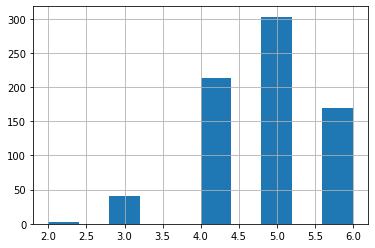

In [14]:
nt['tail_abs_rank_pos'].hist(bins=10)

In [16]:
nt['tail_abs_rank_pos'].describe()

count    731.000000
mean       4.815321
std        0.868054
min        2.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        6.000000
Name: tail_abs_rank_pos, dtype: float64

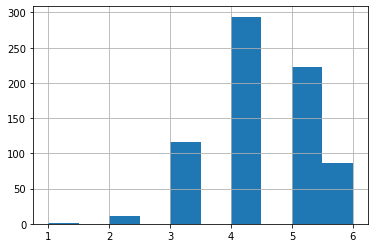

In [15]:
nt['tail_sma_1_rank_pos'].hist(bins=10)

In [17]:
nt['tail_sma_1_rank_pos'].describe()

count    731.000000
mean       4.348837
std        0.943650
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: tail_sma_1_rank_pos, dtype: float64

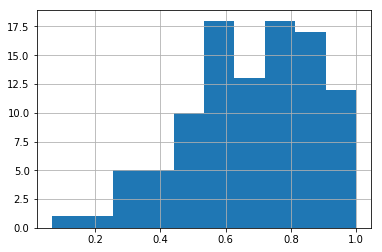

In [30]:
nt['tail_cdf'].hist(bins=10)

In [31]:
nt['tail_cdf'].describe()

count    100.000000
mean       0.681982
std        0.198568
min        0.067421
25%        0.556303
50%        0.687288
75%        0.834453
max        0.999844
Name: tail_cdf, dtype: float64

In [32]:
np.argmax(nt['tail_cdf'])

/home/trentonbricken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


26

(0, 60)

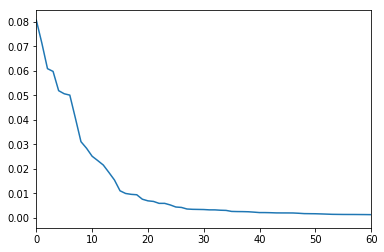

In [389]:
from scipy.special import softmax


ind = 5



sps = softmax(-np.sort(-all_logits[0, :, ind])) #sorted probabilities
plt.plot(np.arange(0,50257),  sps )
#plt.set_autoscaley_on(False)
plt.xlim([0,60])

# FFT

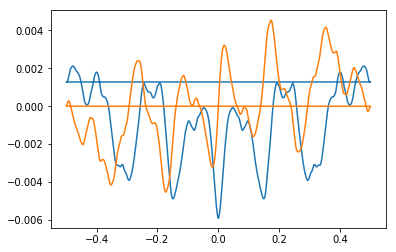

In [308]:
# discreet fast fourier transform

fourier = np.fft.fft(second)

freq = np.fft.fftfreq(second.shape[0])
plt.plot(freq, fourier.real, freq, fourier.imag)

In [309]:
fourier.shape

(50255,)

# QQ plot

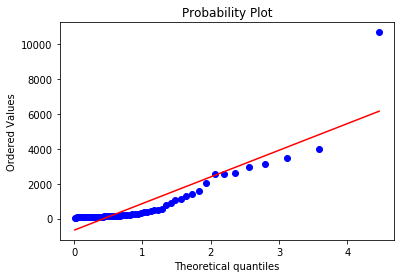

In [310]:
# qq plot with exponential
from scipy import stats

samps = stats.multinomial.rvs(50000, sps[:60])

fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(samps, dist=stats.expon, plot=ax);


In [311]:
np.quantile(sps, np.arange(0,1,0.2))

array([5.82001547e-15, 1.75382724e-09, 1.25925800e-08, 7.76647070e-08,
       6.13551049e-07])

# EMA 

(0, 60)

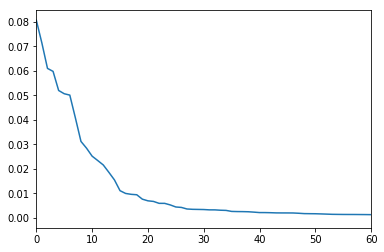

In [332]:
#VECTORIZED IMPLEMENTATION: 

'''https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm'''

alpha = 0.99

ema = []
for i in range(sps.shape[0]):
    if i == 0:
        ema.append(sps[i])
    else: 
        ema.append( (alpha*sps[i]) + ((1-alpha)*ema[i-1]) )
        
ema = np.asarray(ema)
plt.plot(np.arange(0,50257), ema)
plt.xlim([0,60])

### EMA from the other direction!

In [333]:
rev_sps = softmax(np.sort(all_logits[0, :, ind]))

(0, 60)

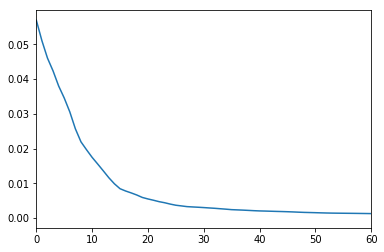

In [413]:
alpha = 0.2

ema = []
for i in range(sps.shape[0]):
    if i == 0:
        ema.append(rev_sps[i])
    else: 
        ema.append( (alpha*rev_sps[i]) + ((1-alpha)*ema[i-1]) )
        
ema = np.asarray(ema)
plt.plot(np.arange(0,50257), np.flip(ema))
plt.xlim([0,60])

In [414]:
ema = np.flip(ema) # filp it so that it makes the reverse! 

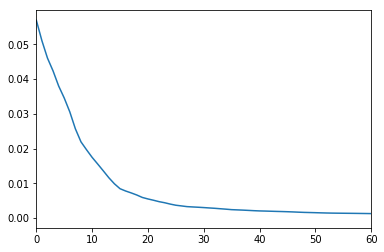

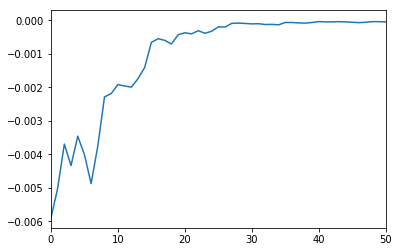

second


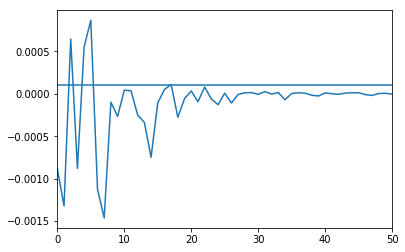

"print('third')\nthird =  second[:-1] - second[1:]\nplt.plot(np.arange(0,50254), third )\nplt.xlim([0,50])\nplt.show()\nprint('fourth')\nfourth =  third[:-1] - third[1:]\nplt.plot(np.arange(0,50253), fourth )\nplt.xlim([0,50])\nplt.show()\nprint('fifth')\nfifth =  fourth[:-1] - fourth[1:]\nplt.plot(np.arange(0,50252), fifth )\nplt.xlim([0,50])\nplt.show()"

In [415]:
#EMA plots: 
plt.plot(np.arange(0,50257),  ema )
plt.xlim([0,60])
plt.show()
first = ema[1:] - ema[:-1]
plt.plot(np.arange(0,50256), first ) # 1st order derivative.
plt.xlim([0,50])
plt.show()
print('second')
second = first[:-1]-first[1:]

plt.plot(np.arange(0,50255), second ) # 1st order derivative.
plt.xlim([0,50])
plt.axhline(0.0001)
plt.show()
'''print('third')
third =  second[:-1] - second[1:]
plt.plot(np.arange(0,50254), third )
plt.xlim([0,50])
plt.show()
print('fourth')
fourth =  third[:-1] - third[1:]
plt.plot(np.arange(0,50253), fourth )
plt.xlim([0,50])
plt.show()
print('fifth')
fifth =  fourth[:-1] - fourth[1:]
plt.plot(np.arange(0,50252), fifth )
plt.xlim([0,50])
plt.show()'''

In [416]:
second.shape[0]-np.argmax(np.flip(second)>0.0001)

18

In [319]:
ema[0:20]

array([0.05697669, 0.05107671, 0.04605993, 0.04236351, 0.03802513,
       0.0345649 , 0.03055467, 0.02567963, 0.02192961, 0.01964184,
       0.01745369, 0.0155327 , 0.0135702 , 0.01157279, 0.00982673,
       0.00841857, 0.00775869, 0.00720739, 0.00660649, 0.00589781])

# Normal, not EMA, with or without rounding

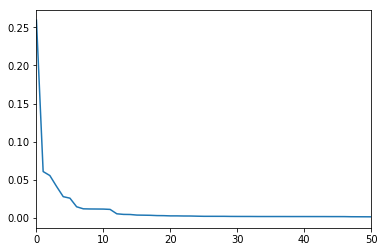

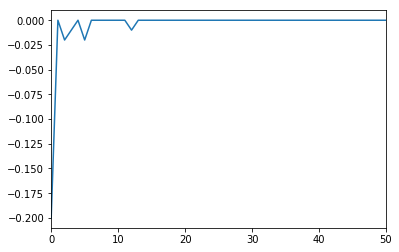

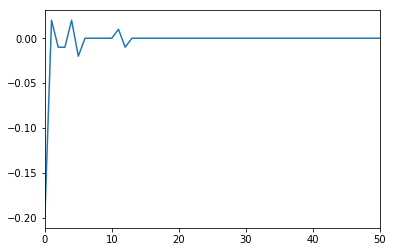

In [426]:
plt.plot(np.arange(0,50257),  sps )
plt.xlim([0,50])
plt.show()
sps= np.around(sps,2) # round it up so it is more precise. 
first = sps[1:] - sps[:-1]
plt.plot(np.arange(0,50256), first ) # 1st order derivative.
plt.xlim([0,50])
plt.show()

second = first[:-1]-first[1:]
plt.plot(np.arange(0,50255), second ) # 1st order derivative.
plt.xlim([0,50])
plt.show()

In [391]:
second.shape[0]-np.argmax(np.flip(second)>0.001)

18

In [384]:
sum(np.flip(second)>0.0025)

5

In [386]:
np.flip(second)>0.0025

array([False, False, False, ...,  True, False, False])

In [388]:
second.shape[0]-np.argmax(np.flip(second)>0.001)

24

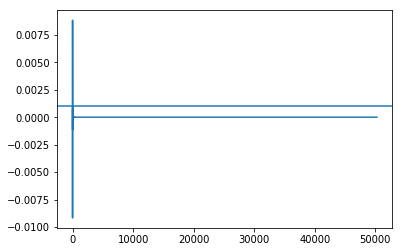

In [325]:
second = first[:-1]-first[1:]
plt.plot(np.arange(0,50255), second ) # 1st order derivative.
#plt.xlim([0,50])
plt.axhline(0.001)
plt.show()

In [324]:
np.argmax(np.flip(second)>0.001)

50237

# Variance

gap being used 2 note that the axes are relative to the gaps!


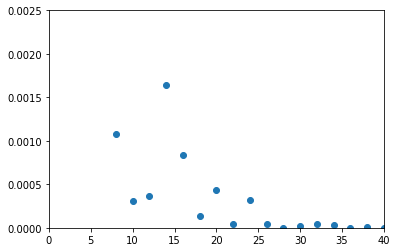

===========Plot of the sums===========


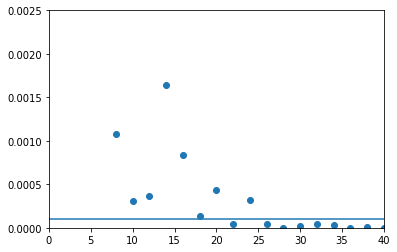

In [298]:
# variance over time plot
gaps = [2]
for ind, g in enumerate(gaps):
    print('gap being used', g, 'note that the axes are relative to the gaps!')
    gap = g
    variable = second #VARIABLE WE WANT TO USE HERE!
    r = np.arange(0,variable.shape[0],gap)    
    var_w = []
    for s, e in zip(r, r+gap):
        var_w.append(np.var(variable[s:e]))
    var_w = np.asarray(var_w) *1000
    
    if ind==0:
        w_sums = var_w
        ref_gap = r
    else: 
        w_sums+=np.interp(ref_gap, r, var_w)
        
    plt.scatter(r, var_w )
    plt.xlim([0,40])
    plt.ylim([0.0,0.0025])
    plt.show()
print('===========Plot of the sums===========')
w_sums/=len(gaps)
plt.scatter(ref_gap, w_sums)
plt.xlim([0,40])
plt.ylim([0.0,0.0025])
plt.axhline(0.0001)
plt.show()

(0.0, 0.0025)

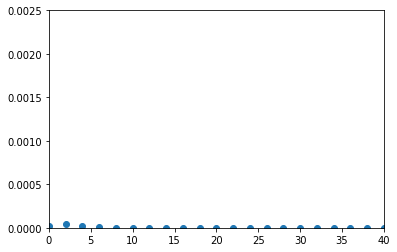

In [291]:
plt.scatter(ref_gap, var_w)
plt.xlim([0,40])
plt.ylim([0.0,0.0025])

# EMA of the second

(-0.02, 0.05)

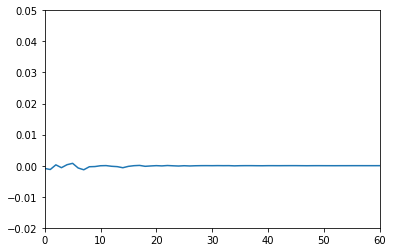

In [417]:

#ema of the second!
alpha = 0.8

ema_second = []
for i in range(second.shape[0]):
    if i == 0:
        ema_second.append(second[i])
    else: 
        ema_second.append( (alpha*second[i]) + ((1-alpha)*ema_second[i-1]) )
        
ema_second = np.asarray(ema_second)
plt.plot(np.arange(0,second.shape[0]),  ema_second )
plt.xlim([0,60])
plt.ylim([-0.02,0.05])

In [201]:
ema_second[0:20]

array([-0.0506064 , -0.04181475, -0.03488973, -0.02773416, -0.02307863,
       -0.01818861, -0.01414815, -0.01128965, -0.00924893, -0.008019  ,
       -0.00587172, -0.00483852, -0.00400853, -0.00346762, -0.00276937,
       -0.00196961, -0.00174424, -0.00146193, -0.00117966, -0.00086406])

In [206]:
ema_second[0:20]>-0.01

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [184]:
second[0:10] #add 2 to whatever the highest value is here and this is where the tail begins. 

array([-0.0506064 , -0.00664818, -0.00718961,  0.00088811, -0.00445651,
        0.00137146,  0.00201371,  0.00014435, -0.00108604, -0.0030993 ],
      dtype=float32)

(0, 50)

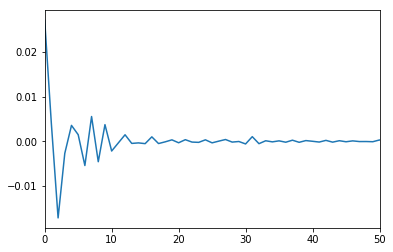

In [137]:
third =  second[:-1] - second[1:]
plt.plot(np.arange(0,50254), third )
plt.xlim([0,50])

In [112]:
np.argmax(second)+1

2

# trying to use linear regression: 



(0, 60)

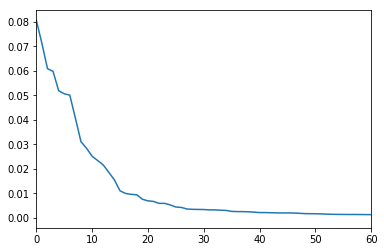

In [374]:
'''ind = 16
sps = softmax(-np.sort(-all_logits[0, :, ind]))'''

plt.plot(np.arange(0,50257),  np.around(sps,5) )
#plt.set_autoscaley_on(False)
plt.xlim([0,60])

(0, 60)

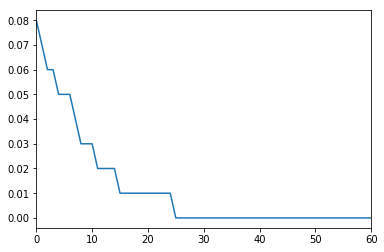

In [375]:
plt.plot(np.arange(0,50257),  np.around(sps,2) )
#plt.set_autoscaley_on(False)
plt.xlim([0,60])

In [372]:
np.around(sps,3)

array([0.081, 0.071, 0.061, ..., 0.   , 0.   , 0.   ], dtype=float32)

In [367]:
import pandas as pd
df = pd.DataFrame(np.arange(0,sps.shape[0]))
df['1'] = df[0]**2
df.head()

,0,1
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16


In [368]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(df,sps)
print('intercept', lr.intercept_ , 'coef', lr.coef_)

intercept 0.00017602934654770608 coef [-1.39341695e-08  2.30439342e-13]


(0, 60)

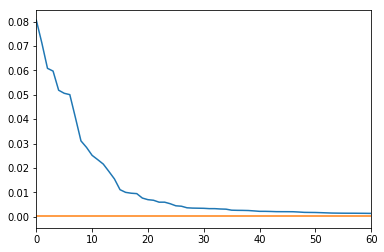

In [370]:
plt.plot(np.arange(0,sps.shape[0]),  sps )
plt.plot(np.arange(0,sps.shape[0]), lr.intercept_+np.arange(0,sps.shape[0])*lr.coef_[0]+np.arange(0,sps.shape[0])*lr.coef_[1])
plt.xlim([0,60])